# VarnaAir - Open Programme

## Introduction ℹ️
VarnaAir is a machine learning project focused on predicting the Air Quality Index (AQI) for Varna, Bulgaria. The project applies regression models to forecast AQI levels.

I chose Varna for this project because it is my hometown and I deeply care about the environmental impact of air pollution. As a coastal city, Varna faces significant pollution from its seaport, as well as from the airport and increasing traffic levels. 

More importantly, it is where my family and friends live, so their health and well-being are a strong personal motivation behind this project.


## Libraries 📚
First, let's begin by importing the libraries and checking their versions.

In [1787]:
import numpy
import pandas
import sklearn
import seaborn
import requests
import datetime
from pytz import timezone
from sklearn.svm import SVR
from datetime import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

print("Library versions:")
print("- numpy:", numpy.__version__)                #2.1.3
print("- pandas:", pandas.__version__)              #2.2.3
print("- sklearn:", sklearn.__version__)            #1.6.1
print("- seaborn:", seaborn.__version__)            #0.13.1
print("- requests:", requests.__version__)          #2.31.0
print("- matplotlib:", plt.matplotlib.__version__)  #3.10.0

Library versions:
- numpy: 2.1.3
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2
- requests: 2.31.0
- matplotlib: 3.10.0


## Data provisioning 📦

Next, we will use a free to use API key provided by Air Pollution API [https://openweathermap.org/api/air-pollution].

Besides basic Air Quality Index, the API returns data about polluting gases, such as Carbon monoxide (CO), Nitrogen monoxide (NO), Nitrogen dioxide (NO2), Ozone (O3), Sulphur dioxide (SO2), Ammonia (NH3) and particulates (PM2.5 and PM10).

The data spans from January 1, 2023 (00:00:00 Europe/Sofia's timezone) to June 28, 2025 (00:00:00 Europe/Sofia's timezone) as of today.

Varna shares the same time zone as the capital city - Sofia.

In [1788]:
sofia_tz = timezone('Europe/Sofia')

start_date = datetime(2023, 1, 1, 0, 0, 0, tzinfo=sofia_tz)   # January 1, 2023, 00:00:00 Sofia time
end_date = datetime(2025, 6, 28, 0, 0, 0, tzinfo=sofia_tz)    # June 28, 2025, 00:00:00 Sofia time

start = int(start_date.timestamp())
end = int(end_date.timestamp())

print("Start timestamp:", start)
print("End timestamp:", end)

Start timestamp: 1672525620
End timestamp: 1751063220


The API call "Historical air pollution data" I am using is:

`http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={API key}`

In order to explain the request, I will explain each query parameters:
- lat: 43.224389 corresponds to the latitude of Varna, Bulgaria.
- lon: 27.915733 corresponds to the longitude of Varna, Bulgaria.
- start: 1672525620 corresponds to January 1, 2023, 00:00:00 Sofia time.
- end: 1751063220 corresponds to June 28, 2025, 00:00:00 Sofia time.
- appid: 6964febcb17ba6ff6b81e9dc9f05d7cc is my API key, which authenticates the request with the OpenWeatherMap API.

In [1789]:
url = "http://api.openweathermap.org/data/2.5/air_pollution/history?lat=43.224389&lon=27.915733&start=1672525620&end=1751063220&appid=6964febcb17ba6ff6b81e9dc9f05d7cc"

response = requests.get(url)

data = response.json()
data_list = data.get('list', [])

df = pandas.json_normalize(data_list)
df['dt'] = pandas.to_datetime(df['dt'], unit='s').dt.tz_localize('UTC').dt.tz_convert(sofia_tz)

df

dt  main.aqi  components.co  components.no  \
0     2023-01-01 01:00:00+02:00       2.0         337.12           0.16   
1     2023-01-01 02:00:00+02:00       2.0         300.41           0.05   
2     2023-01-01 03:00:00+02:00       2.0         283.72           0.01   
3     2023-01-01 04:00:00+02:00       2.0         280.38           0.01   
4     2023-01-01 05:00:00+02:00       2.0         283.72           0.01   
...                         ...       ...            ...            ...   
21331 2025-06-27 21:00:00+03:00       2.0         108.72           0.00   
21332 2025-06-27 22:00:00+03:00       2.0         109.85           0.00   
21333 2025-06-27 23:00:00+03:00       2.0         111.90           0.00   
21334 2025-06-28 00:00:00+03:00       2.0         113.24           0.00   
21335 2025-06-28 01:00:00+03:00       2.0         112.74           0.00   

       components.no2  components.o3  components.so2  components.pm2_5  \
0               18.34          12.16            2.38             21.40   
1               14.74          18.78            2.26             17.98   
2               11.48          28.61            2.18             15.54   
3               10.11          30.76            2.12             14.57   
4                9.51          31.47            2.15             14.03   
...               ...            ...             ...               ...   
21331            1.27          86.86            0.94              5.25   
21332            1.38          81.64            1.04              5.09   
21333            1.58          75.80            1.09              5.00   
21334            1.71          70.80            1.08              4.85   
21335            1.76          62.56            0.95              4.72   

       components.pm10  components.nh3  
0                24.74            0.17  
1                20.54            0.13  
2                17.46            0.09  
3                16.24            0.09  
4                15.58            0.10  
...                ...             ...  
21331             6.22            1.01  
21332             6.00            1.12  
21333             5.90            1.31  
21334             5.73            1.48  
21335             5.57            1.74  

[21336 rows x 10 columns]

Since the winter is +2:00 UTC and the summer is +3:00 there is some differences in the format of the datetimein in the beginning and the end.

To enhance readability and ensure clarity, we will rename the columns to make them more descriptive and consistent.

In [1790]:
df.rename(columns={"dt": "datetime_UTC", 
                   "main.aqi": "AQI",
                   "components.co": "CO",
                   "components.no": "NO",
                   "components.no2": "NO2",
                   "components.o3": "O3",
                   "components.so2": "SO2",
                   "components.pm2_5": "PM2_5",
                   "components.pm10": "PM10",
                   "components.nh3": "NH3"}, inplace=True)
df

datetime_UTC  AQI      CO    NO    NO2     O3   SO2  PM2_5  \
0     2023-01-01 01:00:00+02:00  2.0  337.12  0.16  18.34  12.16  2.38  21.40   
1     2023-01-01 02:00:00+02:00  2.0  300.41  0.05  14.74  18.78  2.26  17.98   
2     2023-01-01 03:00:00+02:00  2.0  283.72  0.01  11.48  28.61  2.18  15.54   
3     2023-01-01 04:00:00+02:00  2.0  280.38  0.01  10.11  30.76  2.12  14.57   
4     2023-01-01 05:00:00+02:00  2.0  283.72  0.01   9.51  31.47  2.15  14.03   
...                         ...  ...     ...   ...    ...    ...   ...    ...   
21331 2025-06-27 21:00:00+03:00  2.0  108.72  0.00   1.27  86.86  0.94   5.25   
21332 2025-06-27 22:00:00+03:00  2.0  109.85  0.00   1.38  81.64  1.04   5.09   
21333 2025-06-27 23:00:00+03:00  2.0  111.90  0.00   1.58  75.80  1.09   5.00   
21334 2025-06-28 00:00:00+03:00  2.0  113.24  0.00   1.71  70.80  1.08   4.85   
21335 2025-06-28 01:00:00+03:00  2.0  112.74  0.00   1.76  62.56  0.95   4.72   

        PM10   NH3  
0      24.74  0.17  
1      20.54  0.13  
2      17.46  0.09  
3      16.24  0.09  
4      15.58  0.10  
...      ...   ...  
21331   6.22  1.01  
21332   6.00  1.12  
21333   5.90  1.31  
21334   5.73  1.48  
21335   5.57  1.74  

[21336 rows x 10 columns]

## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the key variables used in this dataset:

| No. | Column Name     | Unit     | Description                                                          | Good    | Moderate  | Bad                  |
|-----|-----------------|----------|----------------------------------------------------------------------|---------|-----------|----------------------|
| 1   | datetime_local  | datetime | Local date and time of the air quality measurement.                  |    -    |     -     |   -                  |
| 2   | AQI             | 1-5      | Air Quality Index value calculated based on pollutant concentrations.|1-2(Good)|3(Moderate)|4-5(Poor to Very Poor)|
| 3   | CO              | µg/m³    | Concentration of carbon monoxide (CO).                               |0-500    |501-1000	|>1000                 |
| 4   | NO              | µg/m³    | Concentration of nitrogen monoxide (NO).                             |0-0.2    |0.21-0.5   |>0.5                  |
| 5   | NO2             | µg/m³    | Concentration of nitrogen dioxide (NO₂).                             |0-20     |21-40  	|>40                   |
| 6   | O3              | µg/m³    | Concentration of ozone (O₃).                                         |0-50     |51-1000	|>100                  |
| 7   | SO2             | µg/m³    | Concentration of sulfur dioxide (SO₂).                               |0-5      |6-10    	|>10                   |
| 8   | PM2_5           | µg/m³    | Concentration of particulate matter with diameter ≤ 2.5 µm (PM₂.₅).  |0-25     |26-50  	|>50                   |
| 9   | PM10            | µg/m³    | Concentration of particulate matter with diameter ≤ 10 µm (PM₁₀).    |0-50     |51-100 	|>100                  |
| 10  | NH3             | µg/m³    | Concentration of ammonia (NH₃).                                      |0-0.5    |0.6-1  	|>1                    |

To better understand each value, I will explain them one by one:

**AQI (Air Quality Index)**
- The AQI is a standardized tool used to communicate how polluted the air currently is or how polluted it is forecast to become. It converts complex air quality data into a single number and category for ease of understanding.
- The AQI is calculated based on the concentrations of key pollutants. Each pollutant's concentration is mapped to an index value using pollutant-specific breakpoints defined by local or international standards.
- *Categories:*
    - **1 (Good):** Air quality poses no risk, and pollution levels are low.
    - **2 (Fair):** Air quality is satisfactory, with little or no risk to health.
    - **3 (Moderate):** Air quality is acceptable, but there may be a concern for some individuals who are particularly sensitive to air pollution.
    - **4 (Poor):** Health effects may be felt by everyone. Members of sensitive groups may experience more serious effects.
    - **5 (Very Poor):** Serious health effects for everyone, with greater risks for sensitive groups. Prolonged exposure should be avoided.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, potentially causing dizziness, confusion, or even fatality at very high levels.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Not directly harmful in most cases but quickly reacts to form NO₂, which has more significant health impacts.

**NO₂ (Nitrogen Dioxide)**
- Key indicator of traffic-related air pollution.
- Formed primarily from the burning of fossil fuels in vehicles (cars, trucks, etc) and power plants.
- Irritates airways, reduces lung function and increases the risk of respiratory infections.
- Contributes to the formation of ozone (O₃) and particulate matter (PM2.5, PM10).

**O₃ (Ground-level Ozone)**
- A secondary pollutant formed from the reaction of sunlight with NOx and VOCs (volatile organic compounds).
- Causes chest pain, coughing, throat irritation and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**PM2.5 (Fine Particulate Matter ≤ 2.5 µm)**
- A major component of AQI calculations and a critical indicator of air quality.
- Very small particles that can penetrate deep into the lungs and enter the bloodstream.
- Linked to respiratory and cardiovascular diseases, cancer and premature death.

**PM10 (Particulate Matter ≤ 10 µm)**
- Larger than PM2.5 but still small enough to enter the respiratory system.
- Causes respiratory irritation, worsens asthma and can lead to chronic lung diseases.
- Often associated with dust, pollen and other coarser particles.

**NH₃ (Ammonia)**
- Released from agricultural activities, such as livestock farming and fertilizer use.
- Reacts with other pollutants to form PM2.5, indirectly affecting respiratory and cardiovascular health.
- Direct exposure to high concentrations can cause irritation of the eyes, nose and throat and may exacerbate respiratory issues.
- While not typically a direct health threat at outdoor levels, its role in forming secondary particulate matter makes it an important factor in air quality management.

### Sample the data 📃
Let's sample the data to check how it looks so far.

In [1791]:
df.sample(10)

datetime_UTC  AQI      CO    NO    NO2      O3    SO2  \
4463  2023-07-09 01:00:00+03:00  2.0  178.58  0.00   0.80   90.12   0.31   
16514 2024-11-29 03:00:00+02:00  1.0  267.03  0.00   4.50   52.93   1.80   
19325 2025-03-29 06:00:00+02:00  2.0  277.04  0.00   4.24   75.10   1.79   
6373  2023-09-26 15:00:00+03:00  2.0  216.96  0.09   0.50   87.26   1.13   
10291 2024-03-10 20:00:00+02:00  3.0  277.04  0.00   2.01  100.14   1.73   
2762  2023-04-29 04:00:00+03:00  2.0  240.33  0.00   3.21   77.25   1.36   
4002  2023-06-19 20:00:00+03:00  2.0  210.29  0.14   2.68   63.66   1.04   
17783 2025-01-21 00:00:00+02:00  4.0  647.54  0.01  38.39   28.97  10.61   
10103 2024-03-03 00:00:00+02:00  2.0  283.72  0.00   5.83   65.09   1.86   
15076 2024-09-30 06:00:00+03:00  2.0  226.97  0.00   0.94   74.39   0.28   

       PM2_5   PM10   NH3  
4463    1.56   1.69  0.78  
16514   5.69   7.07  0.20  
19325  14.47  15.73  0.34  
6373    6.69  15.57  0.37  
10291   6.13   7.27  0.30  
2762    4.27   5.14  1.92  
4002    2.05   2.27  0.36  
17783  50.20  55.11  1.73  
10103  18.88  22.54  0.54  
15076   0.50   0.55  0.12

## Preprocessing 🛠️
Machine learning models learn patterns from the data they are given. If the data contains noise, inconsistencies or errors (e.g. typos, null values, duplicates), the model will likely learn misleading or irrelevant patterns - leading to poor performance and unreliable predictions. To prevent this, it is essential to check all rows that contain missing data. If such rows exist, a decision should be made about whether to remove them.
### Null values 0️⃣

In [1792]:
df.isnull().sum()

datetime_UTC    0
AQI             0
CO              0
NO              0
NO2             0
O3              0
SO2             0
PM2_5           0
PM10            0
NH3             0
dtype: int64

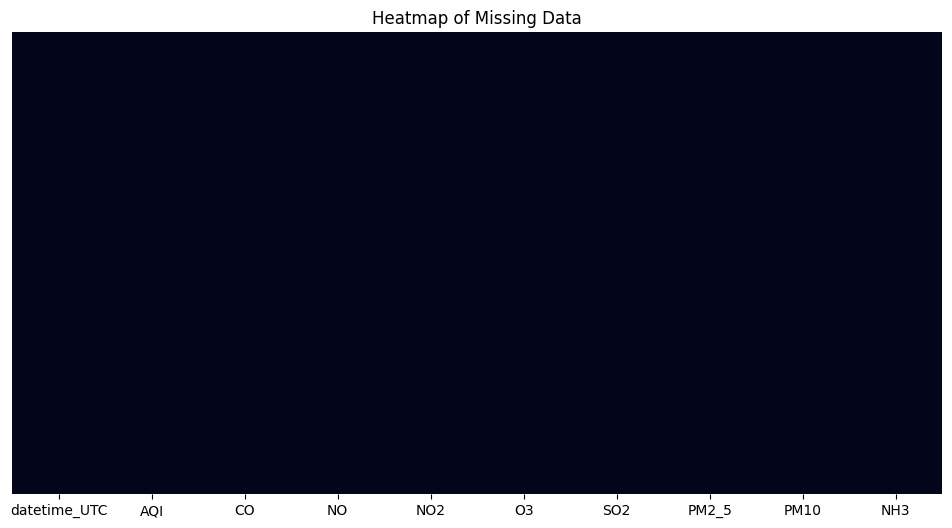

In [1793]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(df.isnull(), cbar=False, cmap='rocket', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

The dataset contains no missing values, so no imputation or removal is required. 

In [1794]:
df.dtypes

datetime_UTC    datetime64[ns, Europe/Sofia]
AQI                                  float64
CO                                   float64
NO                                   float64
NO2                                  float64
O3                                   float64
SO2                                  float64
PM2_5                                float64
PM10                                 float64
NH3                                  float64
dtype: object

There is also no wrong datatypes.

### Duplicates 👯‍♂️
Although the dataset is sourced from a reliable API, it is good practice to verify that there are no duplicate datetime entries to ensure data integrity

In [1796]:
num_duplicate_dt = df.duplicated(subset=['datetime_UTC']).sum()
num_duplicate_all = df.duplicated().sum()

print(f"Number of duplicate timestamps: {num_duplicate_dt}")
print(f"Number of fully duplicate rows: {num_duplicate_all}")

Number of duplicate timestamps: 0
Number of fully duplicate rows: 0


### Format dates 🗓️
Breaking down the datetime into components like year, month, day, hour and weekday helps analyze time-based AQI patterns. It enables detection of seasonal trends, daily/hourly pollution spikes, and weekday vs. weekend differences. These features are crucial for creating lagging variables, modeling temporal dependencies, grouping data, and understanding how time-sensitive factors influence air quality.

In [ ]:
df['year'] = df['datetime_local'].dt.year
df['month'] = df['datetime_local'].dt.month
df['day'] = df['datetime_local'].dt.day
df['hour'] = df['datetime_local'].dt.hour
df['weekday'] = df['datetime_local'].dt.weekday + 1  # Monday=1

AQI      CO    NO    NO2     O3   SO2  PM2_5   PM10   NH3  \
0      2.0  337.12  0.16  18.34  12.16  2.38  21.40  24.74  0.17   
1      2.0  300.41  0.05  14.74  18.78  2.26  17.98  20.54  0.13   
2      2.0  283.72  0.01  11.48  28.61  2.18  15.54  17.46  0.09   
3      2.0  280.38  0.01  10.11  30.76  2.12  14.57  16.24  0.09   
4      2.0  283.72  0.01   9.51  31.47  2.15  14.03  15.58  0.10   
...    ...     ...   ...    ...    ...   ...    ...    ...   ...   
21331  2.0  108.72  0.00   1.27  86.86  0.94   5.25   6.22  1.01   
21332  2.0  109.85  0.00   1.38  81.64  1.04   5.09   6.00  1.12   
21333  2.0  111.90  0.00   1.58  75.80  1.09   5.00   5.90  1.31   
21334  2.0  113.24  0.00   1.71  70.80  1.08   4.85   5.73  1.48   
21335  2.0  112.74  0.00   1.76  62.56  0.95   4.72   5.57  1.74   

         datetime_local  year  month  day  hour  weekday  
0      01-01-2023 01:00  2023      1    1     1        7  
1      01-01-2023 02:00  2023      1    1     2        7  
2      01-01-2023 03:00  2023      1    1     3        7  
3      01-01-2023 04:00  2023      1    1     4        7  
4      01-01-2023 05:00  2023      1    1     5        7  
...                 ...   ...    ...  ...   ...      ...  
21331  27-06-2025 21:00  2025      6   27    21        5  
21332  27-06-2025 22:00  2025      6   27    22        5  
21333  27-06-2025 23:00  2025      6   27    23        5  
21334  28-06-2025 00:00  2025      6   28     0        6  
21335  28-06-2025 01:00  2025      6   28     1        6  

[21336 rows x 15 columns]

## Data Analysis and Visualization 📊
Let's first check the AQI and its values.

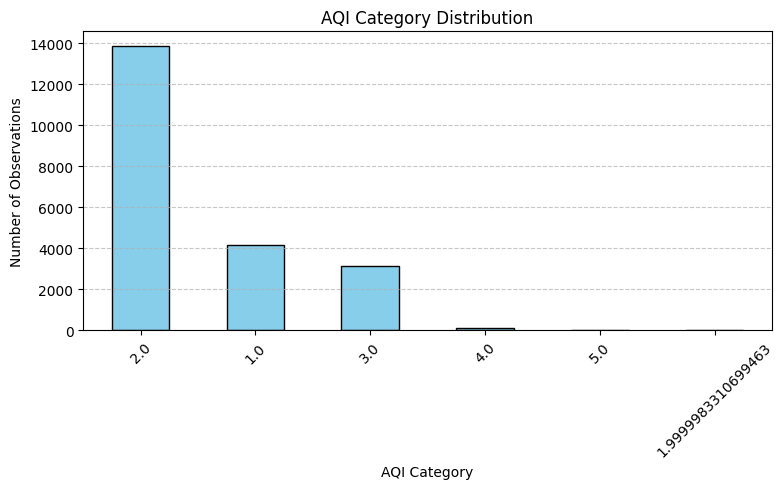

In [ ]:
category_counts = df['AQI'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
df['AQI'].value_counts()

AQI
2.000000    13888
1.000000     4190
3.000000     3129
4.000000      112
5.000000       16
1.999998        1
Name: count, dtype: int64

Since there should be only 1,2,3,4 and 5. We would have to investigate into why the last number is present.

In [ ]:
unique_rows = df[df['AQI'].duplicated(keep=False) == False]
print(unique_rows)

            AQI     CO    NO   NO2     O3   SO2  PM2_5  PM10   NH3  \
20720  1.999998  98.57  0.09  0.41  78.43  0.21    0.0   0.0  1.31   

         datetime_local  year  month  day  hour  weekday  
20720  02-06-2025 10:00  2025      6    2    10        1  


In [ ]:
df = df.dropna() 
df = df[df['AQI'].isin([1, 2, 3, 4, 5])]

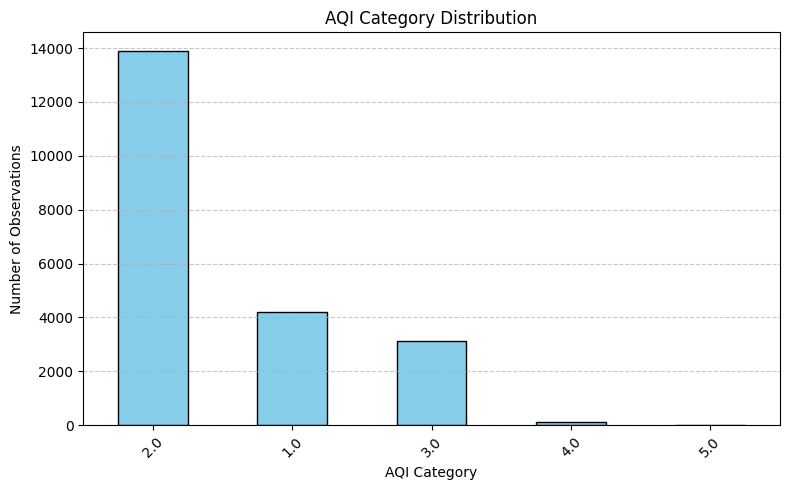

In [ ]:
category_counts = df['AQI'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

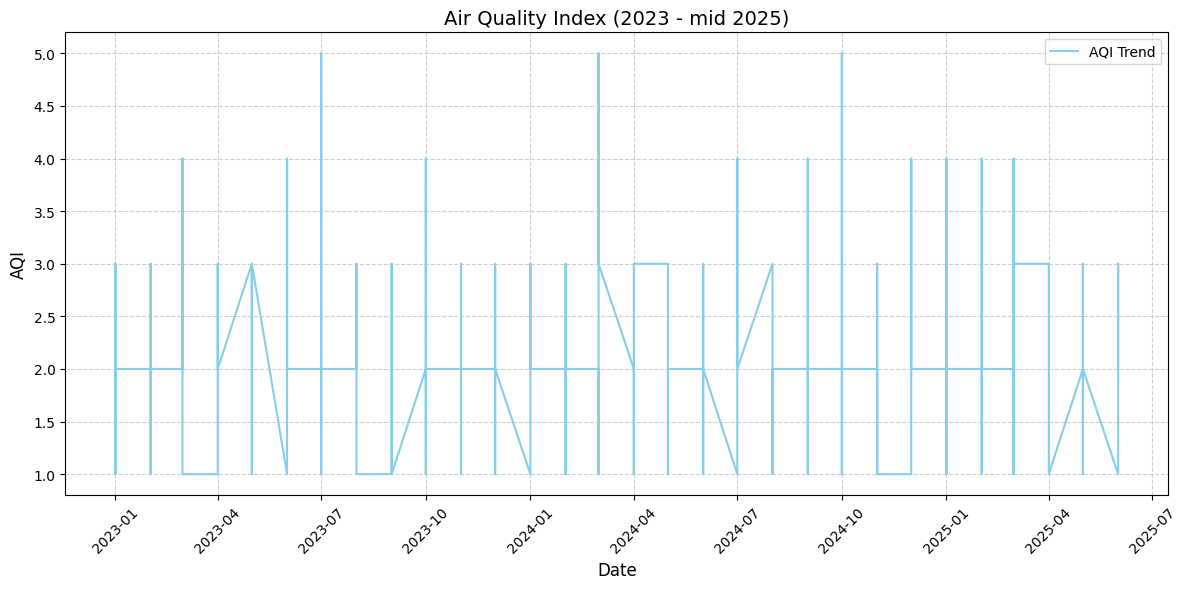

In [ ]:
df["datetime_local"] = pandas.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2),
    format='%Y-%m'
)

df.sort_values(by="datetime_local", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df["datetime_local"], df["AQI"], linestyle='-', color='skyblue', label='AQI Trend')
plt.title("Air Quality Index (2023 - mid 2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("AQI", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.legend()
plt.show()

Overall, There is no clear upward or downward trend in the values. They fluctuate sharply between 1 and 5 throughout the entire period. Peaks (value 5) and troughs (value 1) occur irregularly, with no seasonality or long-term pattern, suggesting that air quality is subject to short-term events rather than long-term changes.

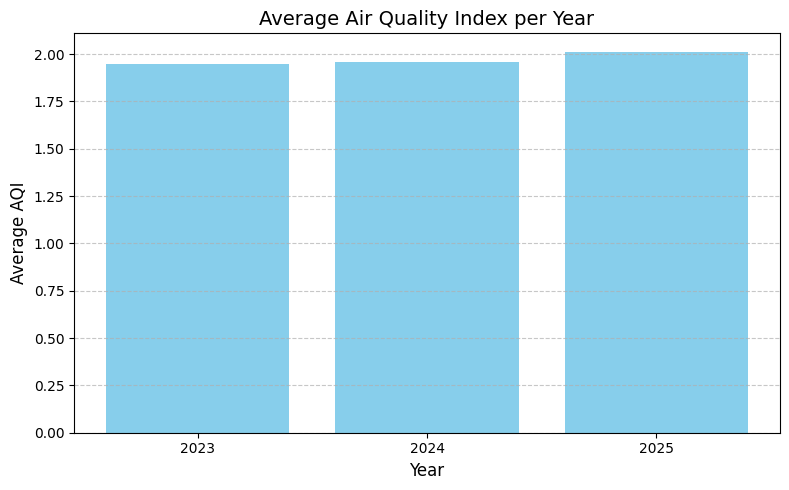

In [ ]:
yearly_avg = df.groupby("year")["AQI"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(yearly_avg["year"], yearly_avg["AQI"], color='skyblue')
plt.title("Average Air Quality Index per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average AQI", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_avg["year"], fontsize=10)
plt.tight_layout()
plt.show()

The data suggests a very mild upward trend in average AQI over the three years, indicating a small deterioration in air quality, but the change is minimal and the overall average remains nearly constant.

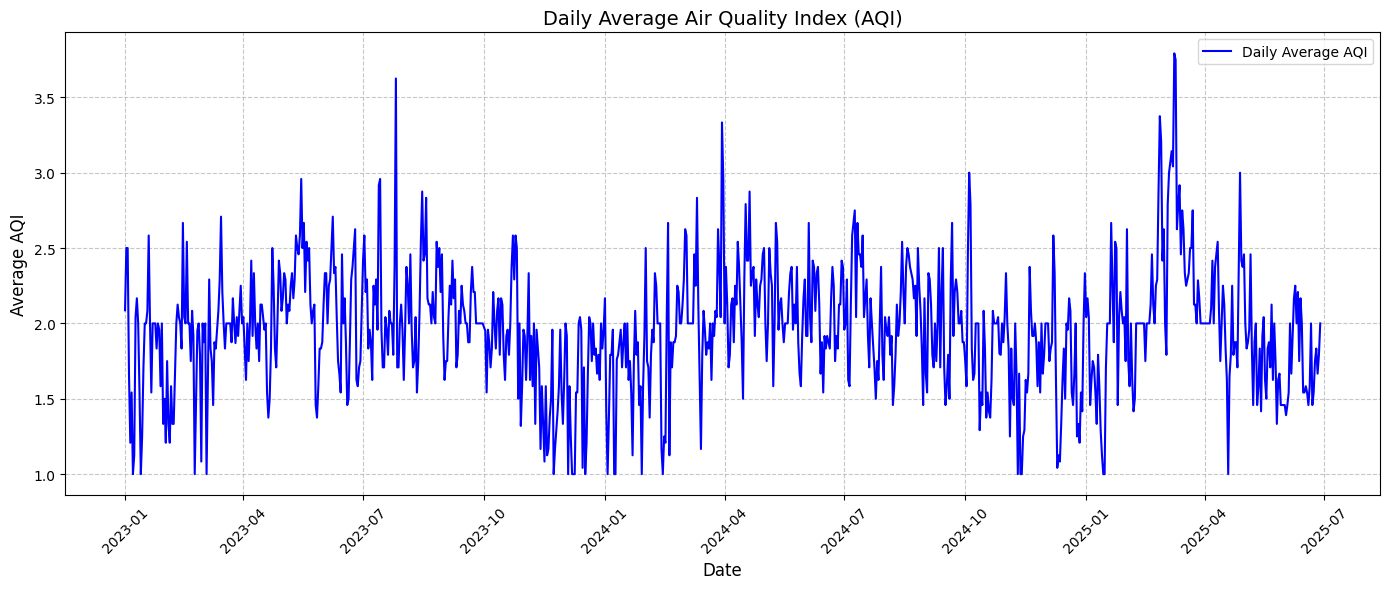

In [ ]:
df["datetime_local"] = pandas.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-" + df["day"].astype(str).str.zfill(2)
)

daily_avg = df.groupby("datetime_local")["AQI"].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_avg["datetime_local"], daily_avg["AQI"], linestyle='-', color='b', label='Daily Average AQI')
plt.title("Daily Average Air Quality Index (AQI)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average AQI", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.legend()
plt.show()

The primary trend observed is significant **daily fluctuation** without a clear, sustained long-term increase or decrease over the two-and-a-half-year period. There appears to be a **possible seasonal pattern**, with noticeable peaks in AQI during summer months (e.g., July-August in 2023 and 2024) and a very prominent high peak in early 2025 (around February-March). Conversely, periods like late 2023 and late 2024 (October-November) show relatively lower AQI values. In essence, the data suggests **volatility and potential seasonality** rather than a strong linear trend in air quality over time.

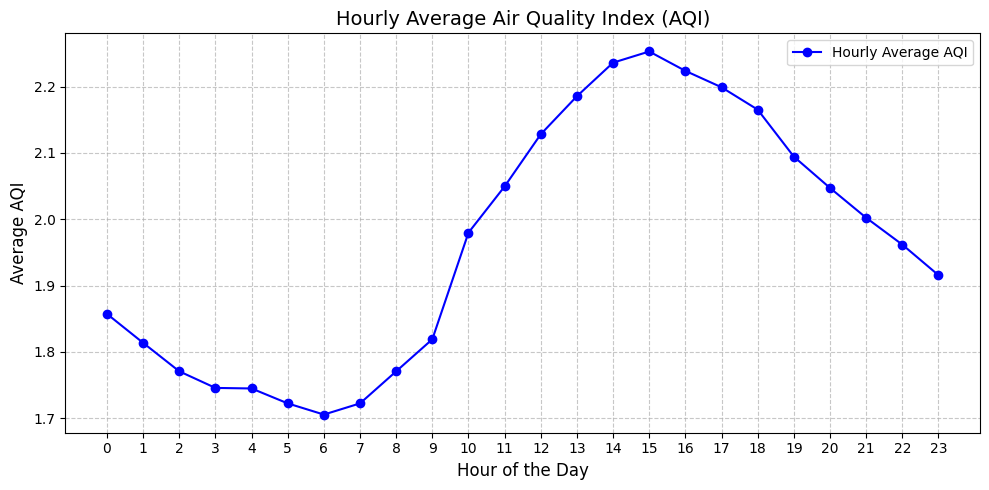

In [ ]:
hourly_avg = df.groupby("hour")["AQI"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg["hour"], hourly_avg["AQI"], marker='o', linestyle='-', color='b', label='Hourly Average AQI')
plt.title("Hourly Average Air Quality Index (AQI)", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average AQI", fontsize=12)
plt.xticks(range(0, 24, 1), fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

Unlike the previous graphs, this one clearly shows a very distinct and strong diurnal (daily) trend. 

The AQI is at its **lowest in the early morning hours (around 6-7 AM)**, bottoming out between 1.7 and 1.75. It then shows a **steady and significant increase throughout the day**, reaching its **peak in the afternoon (between 2 PM and 4 PM)**, with the highest value around 2.25. Following the peak, the AQI **gradually decreases through the evening and night** until midnight. This cyclical pattern indicates that air quality is generally best in the early morning and tends to be worse during the afternoon.

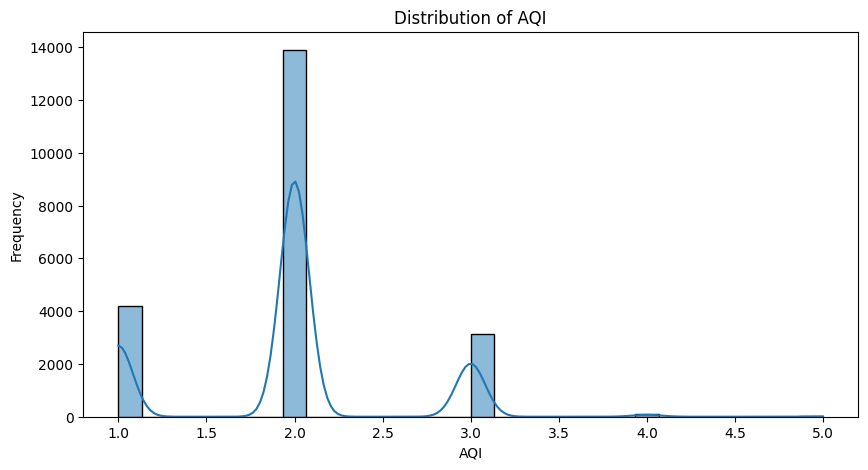

In [ ]:
plt.figure(figsize=(10,5))
seaborn.histplot(df['AQI'], bins=30, kde=True)
plt.title('Distribution of AQI')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

The histogram shows a **multi-modal distribution**, indicating that AQI values are concentrated around several distinct levels rather than being spread uniformly.

The most prominent mode (peak) is observed around an AQI value of **2.0**, which is by far the most frequent occurrence.

Higher AQI values (above 3) are observed very rarely, indicating that extremely poor air quality conditions are uncommon. This multi-modal pattern suggests that AQI values tend to cluster around specific states or conditions.

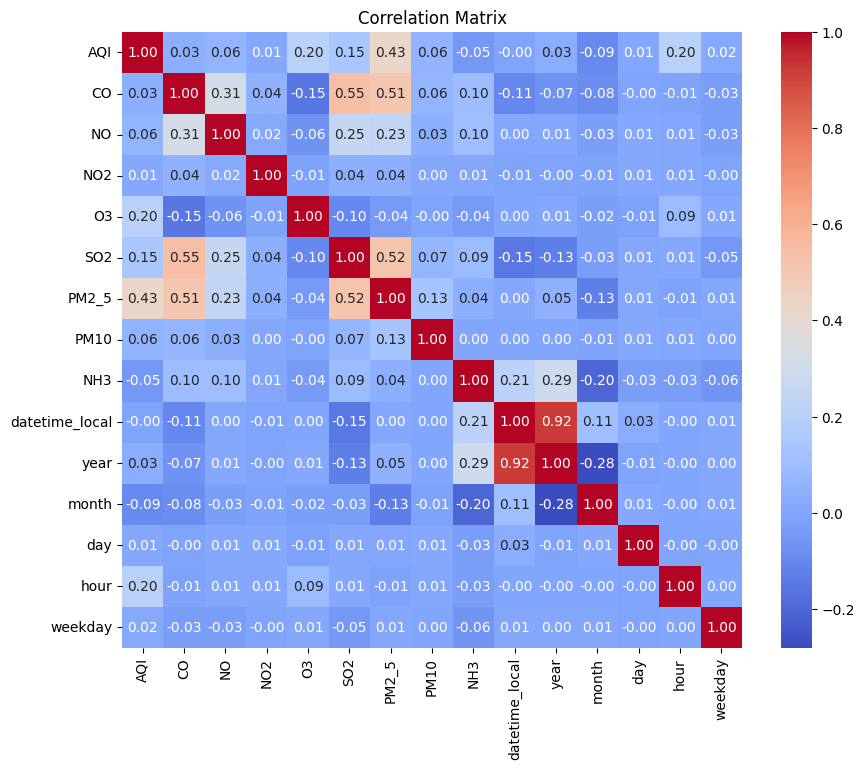

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


- **Strongest Positive Correlation with PM2.5:** AQI shows the strongest positive correlation with **PM2.5 (0.43)**. This suggests that as PM2.5 levels increase, the AQI tends to increase significantly, indicating a strong influence of fine particulate matter on the overall Air Quality Index.
- **Moderate Positive Correlation with PM10 (0.20):** Similarly, PM10 also has a positive correlation with AQI, though not as strong as PM2.5.
- **Weak Positive Correlations:** AQI has weak positive correlations with **CO (0.03)**, **NO (0.06)** and **NO2 (0.04)**.
- **Weak Negative Correlations:** AQI shows weak negative correlations with **O3 (-0.20)**, **SO2 (-0.15)** and **NH3 (-0.04)**. The negative correlation with O3 is notable, suggesting that higher ozone levels might correspond to slightly lower overall AQI or vice-versa, which could be due to complex atmospheric chemistry or the way AQI is calculated from multiple pollutants.
- **Temporal Correlations with AQI:**
    - **Hour (0.20):** There's a notable positive correlation between AQI and the `hour` of the day. This aligns with the previous observation of higher AQI in the afternoon (as seen in the hourly average plot).
    - **Weekday (0.02):** Very weak positive correlation.
    - **Month (0.01) and Day (-0.01):** Almost no linear correlation.
    - **Year (-0.04):** Very weak negative correlation, suggesting a slight, almost negligible, decrease over the years captured.

- **PM2.5 & PM10:** As expected, PM2.5 and PM10 are positively correlated (**0.52**), indicating that their levels often rise and fall together.
- **CO & NO/NO2:** CO shows positive correlations with NO (**0.31**) and NO2 (**0.24**), which are common byproducts of combustion (e.g., vehicle emissions).
- **NO & NO2:** These two are strongly positively correlated (**0.70**), as NO can be oxidized to NO2 in the atmosphere.
- **O3:** O3 generally shows negative or very weak correlations with other primary pollutants like CO (-0.06), NO (-0.22), NO2 (-0.04), SO2 (-0.04), and PM2.5 (-0.04). This is often observed because O3 is a secondary pollutant formed from other precursors in the presence of sunlight, and its concentrations can sometimes be inversely related to primary emissions in certain conditions (e.g., titration by NO).
- **NH3:** NH3 has very weak or negligible correlations with most other pollutants, except for a weak positive correlation with PM2.5 (0.04) and PM10 (0.09), as ammonia can contribute to particulate matter formation.

In [ ]:
df = df.sort_values(by='datetime_local')

# list of lags (in hours) you want to create
lags = [1, 2, 3, 24, 168]

for lag in lags:
    df[f'AQI_lag_{lag}'] = df['AQI'].shift(lag)

df = df.dropna().reset_index(drop=True)

df

AQI      CO    NO   NO2     O3   SO2  PM2_5  PM10   NH3 datetime_local  \
0      1.0  257.02  0.00  5.48  40.05  3.13   6.28  7.14  0.08     2023-01-08   
1      1.0  260.35  0.00  5.31  40.05  2.89   6.35  7.39  0.15     2023-01-08   
2      1.0  260.35  0.00  4.54  43.99  2.68   6.56  7.66  0.18     2023-01-08   
3      1.0  263.69  0.00  4.63  45.06  2.62   6.78  7.93  0.21     2023-01-08   
4      1.0  270.37  0.00  4.93  45.78  2.80   7.41  8.69  0.24     2023-01-08   
...    ...     ...   ...   ...    ...   ...    ...   ...   ...            ...   
21162  2.0  101.85  0.08  0.42  92.04  0.47   5.35  6.68  1.17     2025-06-27   
21163  2.0  102.62  0.10  0.51  91.02  0.47   5.18  6.49  1.22     2025-06-27   
21164  2.0  108.72  0.00  1.27  86.86  0.94   5.25  6.22  1.01     2025-06-27   
21165  2.0  113.24  0.00  1.71  70.80  1.08   4.85  5.73  1.48     2025-06-28   
21166  2.0  112.74  0.00  1.76  62.56  0.95   4.72  5.57  1.74     2025-06-28   

       year  month  day  hour  weekday  AQI_lag_1  AQI_lag_2  AQI_lag_3  \
0      2023      1    8     5        7        1.0        1.0        1.0   
1      2023      1    8     4        7        1.0        1.0        1.0   
2      2023      1    8     2        7        1.0        1.0        1.0   
3      2023      1    8     1        7        1.0        1.0        1.0   
4      2023      1    8     0        7        1.0        1.0        1.0   
...     ...    ...  ...   ...      ...        ...        ...        ...   
21162  2025      6   27    12        5        2.0        2.0        2.0   
21163  2025      6   27    11        5        2.0        2.0        2.0   
21164  2025      6   27    21        5        2.0        2.0        2.0   
21165  2025      6   28     0        6        2.0        2.0        2.0   
21166  2025      6   28     1        6        2.0        2.0        2.0   

       AQI_lag_24  AQI_lag_168  
0             1.0          2.0  
1             1.0          3.0  
2             1.0          3.0  
3             1.0          2.0  
4             1.0          2.0  
...           ...          ...  
21162         1.0          1.0  
21163         1.0          1.0  
21164         2.0          1.0  
21165         1.0          2.0  
21166         2.0          2.0  

[21167 rows x 20 columns]

Creating lag features is a powerful and essential technique in time series analysis. For AQI it allows models to leverage past information, capture temporal dependencies and improve forecasting accuracy. This approach is widely used in both classical statistical models and modern machine learning pipelines for time series prediction.

## Target variable 🎯
We can consider two approaches - one that includes the lags and without - to see which one preforms better.

In [ ]:
y1 = df['AQI']
X1 = df[['year', 'month', 'day', 'hour', 'weekday', 'AQI_lag_1', 'AQI_lag_2', 'AQI_lag_3', 'AQI_lag_24', 'AQI_lag_168']]

In [ ]:
y2 = df['AQI']
X2 = df[['year', 'month', 'day', 'hour', 'weekday']]

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

print("There are in total", len(y1), "observations, of which", len(X1_train), "are now in the train set and", len(X1_test), "in the test set.")

There are in total 21167 observations, of which 16933 are now in the train set and 4234 in the test set.


In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

print("There are in total", len(y2), "observations, of which", len(X2_train), "are now in the train set and", len(X2_test), "in the test set.")

There are in total 21167 observations, of which 16933 are now in the train set and 4234 in the test set.


## Modelling 🧬

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LGBM': LGBMRegressor(force_col_wise=True, verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

results1 = []
for name1, model1 in models.items():
    model1.fit(X1_train, y1_train)
    preds1 = model1.predict(X1_test)
    
    mae1 = mean_absolute_error(y1_test, preds1)
    mse1 = mean_squared_error(y1_test, preds1)
    r2_1 = r2_score(y1_test, preds1)
    
    results1.append((name1, mae1, mse1, r2_1))

results1 = pandas.DataFrame(results1, columns=['Model', 'MAE', 'MSE', 'R²'])
results1 = results1.sort_values('MAE')

results1

Model       MAE       MSE        R²
7                 KNN  0.256920  0.149258  0.606768
1       Random Forest  0.263821  0.155168  0.591198
5             Bagging  0.271941  0.168994  0.554773
11           CatBoost  0.274047  0.153211  0.596355
4         Extra Trees  0.274440  0.169157  0.554344
10               LGBM  0.274950  0.159343  0.580198
2             XGBoost  0.274979  0.160512  0.577119
3   Gradient Boosting  0.298056  0.176640  0.534630
0   Linear Regression  0.320979  0.203421  0.464072
8               Ridge  0.320987  0.203422  0.464071
9               Lasso  0.384792  0.379660 -0.000244
6                 SVR  0.395843  0.370925  0.022769

In [ ]:
results2 = []
for name2, model2 in models.items():
    model2.fit(X2_train, y2_train)
    preds2 = model2.predict(X2_test)
    
    mae2 = mean_absolute_error(y2_test, preds2)
    mse2 = mean_squared_error(y2_test, preds2)
    r2_2 = r2_score(y2_test, preds2)
    
    results2.append((name2, mae2, mse2, r2_2))

results2 = pandas.DataFrame(results2, columns=['Model', 'MAE', 'MSE', 'R²'])
results2 = results2.sort_values('MAE')

results2

Model       MAE       MSE        R²
1       Random Forest  0.192251  0.095011  0.749685
4         Extra Trees  0.198070  0.096133  0.746729
5             Bagging  0.198181  0.110616  0.708573
11           CatBoost  0.308294  0.153906  0.594524
7                 KNN  0.316344  0.186065  0.509797
2             XGBoost  0.331939  0.182088  0.520276
10               LGBM  0.343253  0.194117  0.488584
9               Lasso  0.384792  0.379660 -0.000244
6                 SVR  0.393578  0.372354  0.019006
3   Gradient Boosting  0.405993  0.266636  0.297527
8               Ridge  0.419065  0.357366  0.058492
0   Linear Regression  0.419065  0.357366  0.058492

We can conduct that without the lagging columns the model - Random Forest has a higher R² than KNN with the lagging.

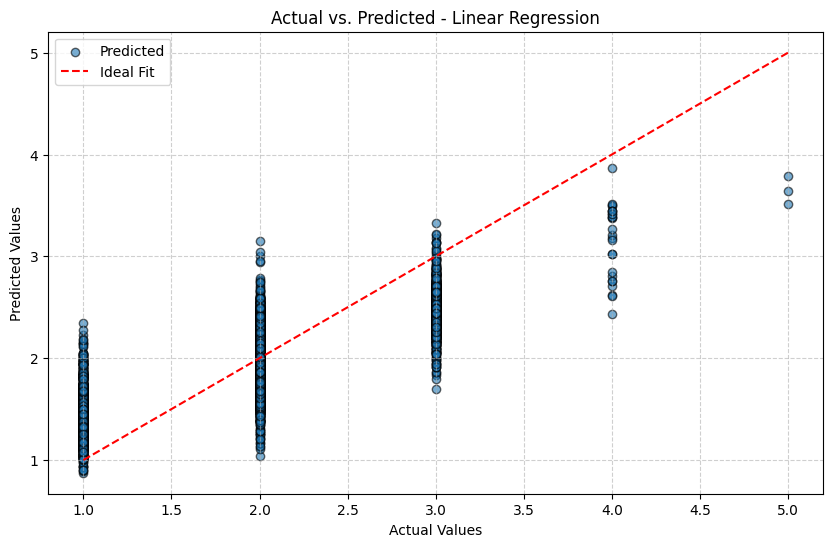

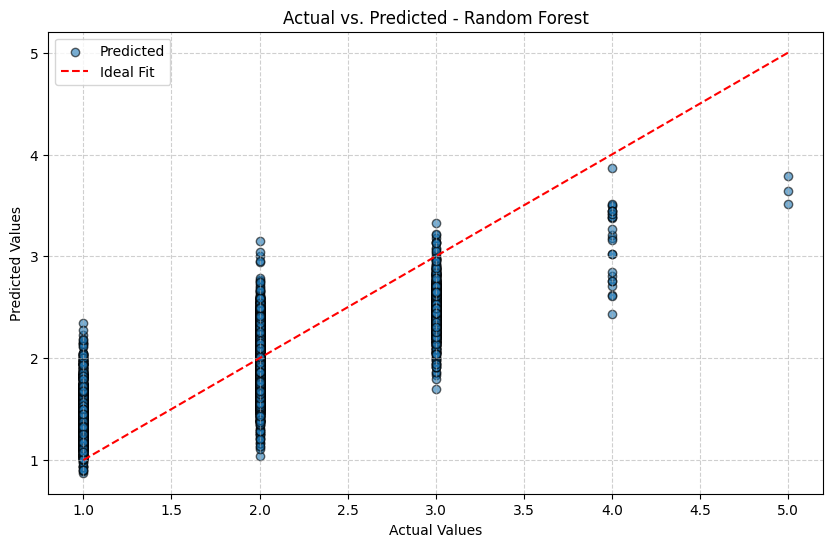

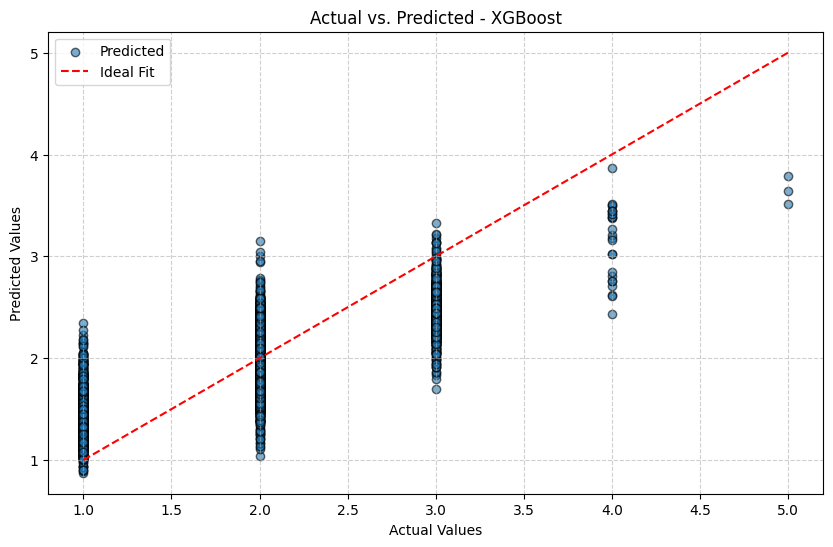

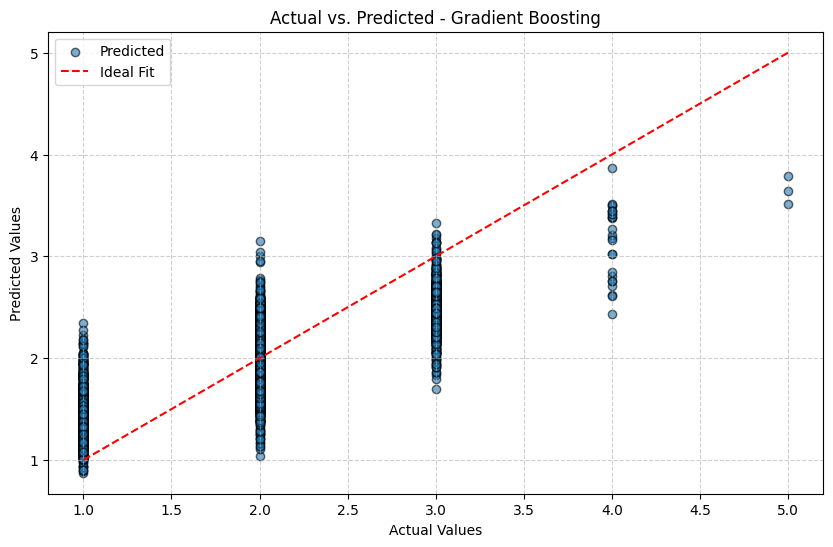

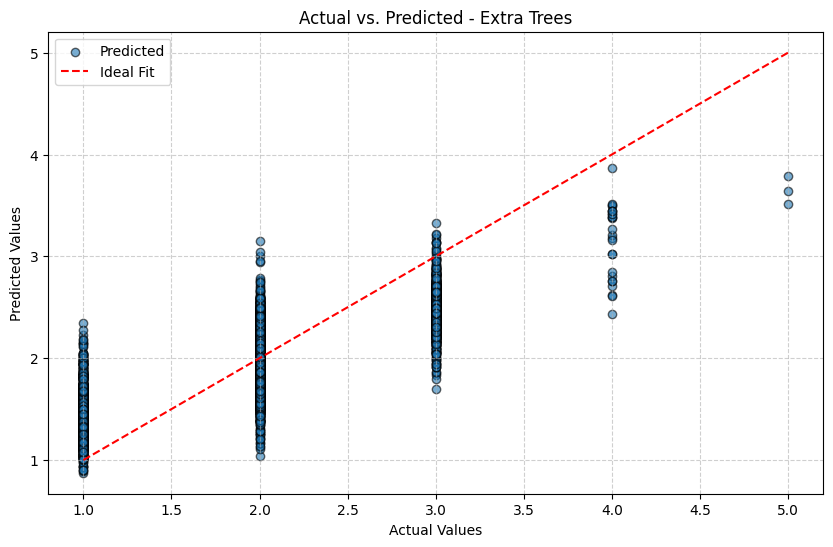

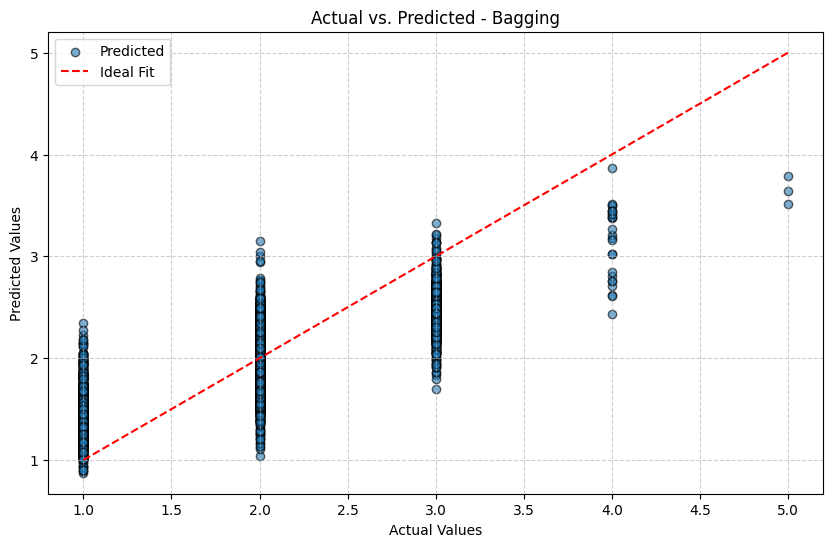

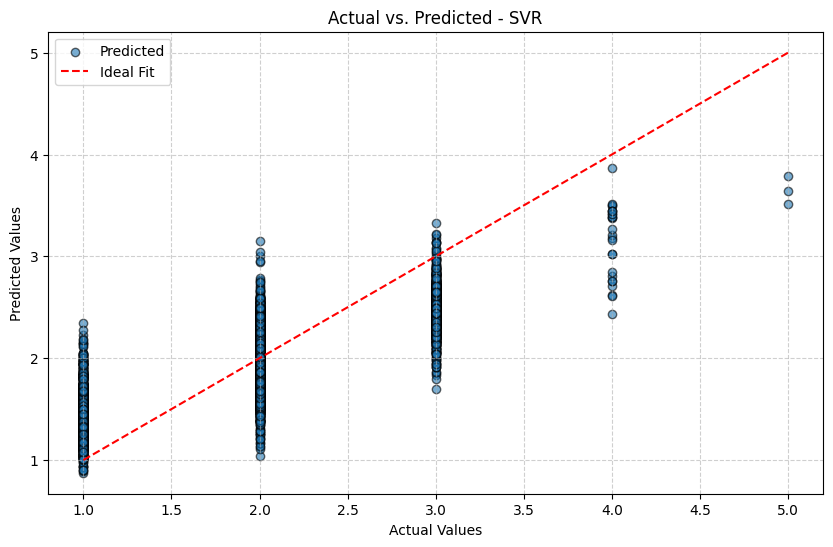

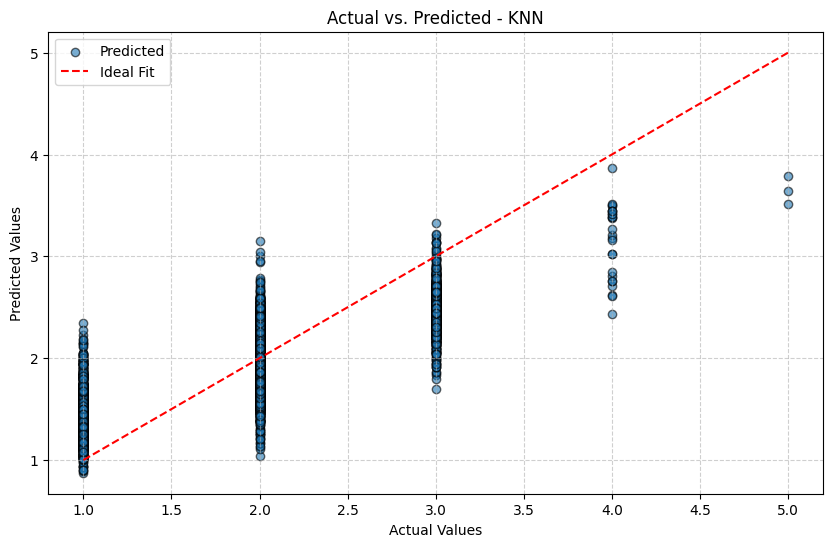

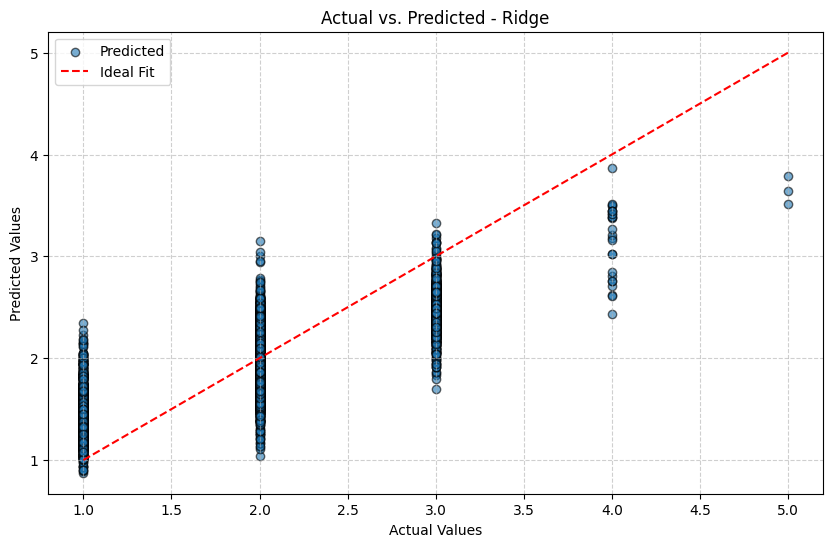

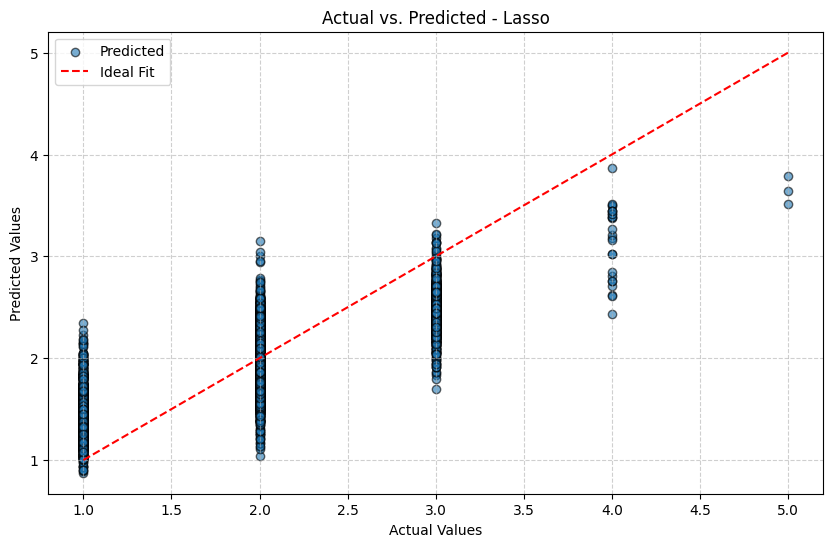

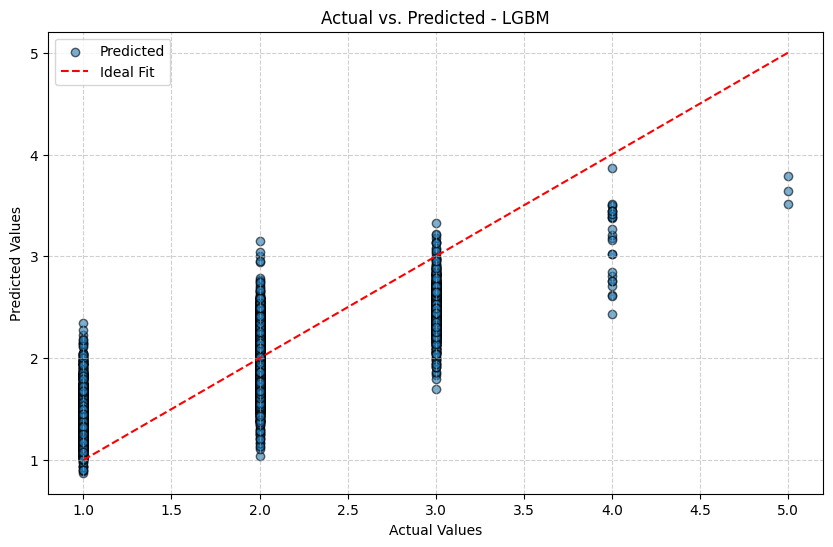

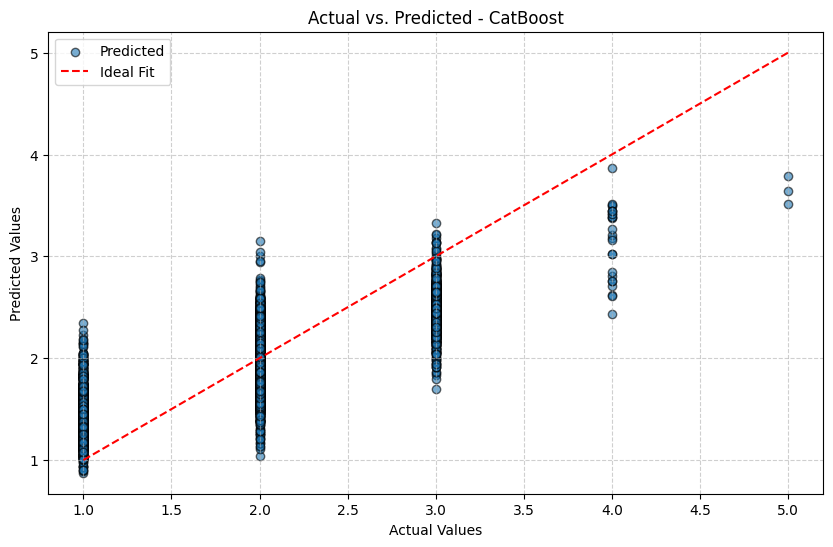

In [ ]:
for name2, model2 in models.items():
    preds = model2.predict(X2_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y2_test, preds2, alpha=0.6, edgecolor='k', label='Predicted')
    plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], 'r--', label='Ideal Fit')
    plt.title(f"Actual vs. Predicted - {name2}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Previous Approach 🔙
Initially, I approached the project using OpenAQ [https://openaq.org/]. However, I found a better API source, so I am discarding this part of the project but keeping it as proof of my work. As there was a huge gap of data between the years.

## Data provisioning 📦

Next, we will use an API key provided by OpenAQ [https://openaq.org/] to check the what Air Monitoring Stations are available in Varna, Bulgaria.

In [ ]:
url = "https://api.openaq.org/v3/locations"
headers = {
    "X-API-Key": "c1061fd64a9bd88562b4bb823b7900ccdfd263a9a7aa54614de834dac611a4ca"
}
params = {
    "coordinates": "43.224389,27.915733",  # center of Varna
    "radius": 5000                         # 5 km radius
}

response = requests.get(url, headers=headers, params=params)

data = response.json().get("results", [])
df_nearby_stations = pandas.DataFrame(data)

print(df_nearby_stations[["id", "name", "locality"]])

        id                         name              locality
0     8843  AMS SOU Angel Kanchev-Varna                 Варна
1  2162113           AMS Chaika - Varna  National air network


Now that the IDs of each location are displayed, I can access each station's sensors to obtain the measurements.

### Angel Kanchev-Varna (part 1)

In [ ]:
url = "https://api.openaq.org/v3/locations/8843/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest1 = pandas.DataFrame(results)

df_latest1

id        name                                          parameter  \
0    25777    o3 µg/m³  {'id': 3, 'name': 'o3', 'units': 'µg/m³', 'dis...   
1    25778   no2 µg/m³  {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...   
2    25776  pm10 µg/m³  {'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...   
3    25779    co µg/m³  {'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...   
4    25774   so2 µg/m³  {'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...   
5    25775  pm25 µg/m³  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   
6  4272879    no µg/m³  {'id': 19843, 'name': 'no', 'units': 'µg/m³', ...   

                                       datetimeFirst  \
0  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
1  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
2  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
3  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
4  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
5  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
6  {'utc': '2023-03-29T18:00:00Z', 'local': '2023...   

                                        datetimeLast  \
0  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
1  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
2  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
3  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
4  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
5  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
6  {'utc': '2024-03-11T11:00:00Z', 'local': '2024...   

                                            coverage  \
0  {'expectedCount': 1, 'expectedInterval': '01:0...   
1  {'expectedCount': 1, 'expectedInterval': '01:0...   
2  {'expectedCount': 1, 'expectedInterval': '01:0...   
3  {'expectedCount': 1, 'expectedInterval': '01:0...   
4  {'expectedCount': 1, 'expectedInterval': '01:0...   
5  {'expectedCount': 1, 'expectedInterval': '01:0...   
6  {'expectedCount': 1, 'expectedInterval': '01:0...   

                                              latest  \
0  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
1  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
2  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
3  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
4  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
5  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
6  {'datetime': {'utc': '2024-03-11T11:00:00Z', '...   

                                             summary  
0  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
1  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
2  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
3  {'min': -1000.0, 'q02': None, 'q25': None, 'me...  
4  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
5  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
6  {'min': 0.14, 'q02': None, 'q25': None, 'media...

In [ ]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Angel Kanchev
sensor_ids = [25777, 25778, 25776, 25779, 25774, 25775, 4272879]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df1 = pandas.DataFrame(results)

        df1 = df1.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df1['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df1['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df1['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df1['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df1['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df1['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df1)

df1 = pandas.concat(sensor_data_frames, ignore_index=True)
df1

value  sensor_id     datetime_from_utc        datetime_from_local  \
0    56.93      25777  2020-04-20T17:00:00Z  2020-04-20T20:00:00+03:00   
1    25.44      25777  2020-04-20T18:00:00Z  2020-04-20T21:00:00+03:00   
2    23.04      25777  2020-04-20T19:00:00Z  2020-04-20T22:00:00+03:00   
3    30.51      25777  2020-04-20T20:00:00Z  2020-04-20T23:00:00+03:00   
4    25.95      25777  2020-04-20T21:00:00Z  2020-04-21T00:00:00+03:00   
..     ...        ...                   ...                        ...   
695  14.49    4272879  2023-04-02T16:00:00Z  2023-04-02T19:00:00+03:00   
696   1.68    4272879  2023-04-02T17:00:00Z  2023-04-02T20:00:00+03:00   
697   1.76    4272879  2023-04-02T18:00:00Z  2023-04-02T21:00:00+03:00   
698   2.85    4272879  2023-04-02T19:00:00Z  2023-04-02T22:00:00+03:00   
699   6.85    4272879  2023-04-02T20:00:00Z  2023-04-02T23:00:00+03:00   

          datetime_to_utc          datetime_to_local parameter_name  \
0    2020-04-20T18:00:00Z  2020-04-20T21:00:00+03:00             o3   
1    2020-04-20T19:00:00Z  2020-04-20T22:00:00+03:00             o3   
2    2020-04-20T20:00:00Z  2020-04-20T23:00:00+03:00             o3   
3    2020-04-20T21:00:00Z  2020-04-21T00:00:00+03:00             o3   
4    2020-04-20T22:00:00Z  2020-04-21T01:00:00+03:00             o3   
..                    ...                        ...            ...   
695  2023-04-02T17:00:00Z  2023-04-02T20:00:00+03:00             no   
696  2023-04-02T18:00:00Z  2023-04-02T21:00:00+03:00             no   
697  2023-04-02T19:00:00Z  2023-04-02T22:00:00+03:00             no   
698  2023-04-02T20:00:00Z  2023-04-02T23:00:00+03:00             no   
699  2023-04-02T21:00:00Z  2023-04-03T00:00:00+03:00             no   

    parameter_units  
0             µg/m³  
1             µg/m³  
2             µg/m³  
3             µg/m³  
4             µg/m³  
..              ...  
695           µg/m³  
696           µg/m³  
697           µg/m³  
698           µg/m³  
699           µg/m³  

[700 rows x 8 columns]

### AMS Chaika - Varna (part 1)
Let's do the same for this station as well.

In [ ]:
url = "https://api.openaq.org/v3/locations/2162113/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest2 = pandas.DataFrame(results)

df_latest2

id        name                                          parameter  \
0  7774820    no µg/m³  {'id': 19843, 'name': 'no', 'units': 'µg/m³', ...   
1  7774916   so2 µg/m³  {'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...   
2  7775044    co µg/m³  {'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...   
3  7775045   no2 µg/m³  {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...   
4  8613114  pm10 µg/m³  {'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...   

                                       datetimeFirst  \
0  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
1  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
2  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
3  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
4  {'utc': '2024-03-18T07:00:00Z', 'local': '2024...   

                                        datetimeLast  \
0  {'utc': '2024-03-11T11:00:00Z', 'local': '2024...   
1  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
2  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
3  {'utc': '2025-06-28T13:00:00Z', 'local': '2025...   
4  {'utc': '2024-06-06T06:00:00Z', 'local': '2024...   

                                            coverage  \
0  {'expectedCount': 1, 'expectedInterval': '01:0...   
1  {'expectedCount': 1, 'expectedInterval': '01:0...   
2  {'expectedCount': 1, 'expectedInterval': '01:0...   
3  {'expectedCount': 1, 'expectedInterval': '01:0...   
4  {'expectedCount': 1, 'expectedInterval': '01:0...   

                                              latest  \
0  {'datetime': {'utc': '2024-03-11T11:00:00Z', '...   
1  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
2  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
3  {'datetime': {'utc': '2025-06-28T13:00:00Z', '...   
4  {'datetime': {'utc': '2024-06-06T06:00:00Z', '...   

                                             summary  
0  {'min': 1.36, 'q02': None, 'q25': None, 'media...  
1  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
2  {'min': -1000.0, 'q02': None, 'q25': None, 'me...  
3  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
4  {'min': -1.0, 'q02': None, 'q25': None, 'media...

In [ ]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Chaika
sensor_ids = [7774820, 7774916, 7775044, 7775045, 8613114]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df2 = pandas.DataFrame(results)

        df2 = df2.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df2['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df2['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df2['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df2['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df2['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df2['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df2)

df2 = pandas.concat(sensor_data_frames, ignore_index=True)
df2

value  sensor_id     datetime_from_utc        datetime_from_local  \
0     1.51    7774820  2024-01-28T22:00:00Z  2024-01-29T00:00:00+02:00   
1     1.65    7774820  2024-01-28T23:00:00Z  2024-01-29T01:00:00+02:00   
2     1.54    7774820  2024-01-29T00:00:00Z  2024-01-29T02:00:00+02:00   
3     1.62    7774820  2024-01-29T01:00:00Z  2024-01-29T03:00:00+02:00   
4     1.66    7774820  2024-01-29T02:00:00Z  2024-01-29T04:00:00+02:00   
..     ...        ...                   ...                        ...   
495  -1.00    8613114  2024-03-29T19:00:00Z  2024-03-29T21:00:00+02:00   
496  -1.00    8613114  2024-03-29T20:00:00Z  2024-03-29T22:00:00+02:00   
497  -1.00    8613114  2024-03-29T21:00:00Z  2024-03-29T23:00:00+02:00   
498  -1.00    8613114  2024-03-29T22:00:00Z  2024-03-30T00:00:00+02:00   
499  -1.00    8613114  2024-03-29T23:00:00Z  2024-03-30T01:00:00+02:00   

          datetime_to_utc          datetime_to_local parameter_name  \
0    2024-01-28T23:00:00Z  2024-01-29T01:00:00+02:00             no   
1    2024-01-29T00:00:00Z  2024-01-29T02:00:00+02:00             no   
2    2024-01-29T01:00:00Z  2024-01-29T03:00:00+02:00             no   
3    2024-01-29T02:00:00Z  2024-01-29T04:00:00+02:00             no   
4    2024-01-29T03:00:00Z  2024-01-29T05:00:00+02:00             no   
..                    ...                        ...            ...   
495  2024-03-29T20:00:00Z  2024-03-29T22:00:00+02:00           pm10   
496  2024-03-29T21:00:00Z  2024-03-29T23:00:00+02:00           pm10   
497  2024-03-29T22:00:00Z  2024-03-30T00:00:00+02:00           pm10   
498  2024-03-29T23:00:00Z  2024-03-30T01:00:00+02:00           pm10   
499  2024-03-30T00:00:00Z  2024-03-30T02:00:00+02:00           pm10   

    parameter_units  
0             µg/m³  
1             µg/m³  
2             µg/m³  
3             µg/m³  
4             µg/m³  
..              ...  
495           µg/m³  
496           µg/m³  
497           µg/m³  
498           µg/m³  
499           µg/m³  

[500 rows x 8 columns]

The next step is to combine both datasets, as we have the latest measurements from both stations.

In [ ]:
combined_df = pandas.concat([df1, df2], ignore_index=True)

print("The API key dataset from the 2 stations contains: " + str(combined_df.shape))

The API key dataset from the 2 stations contains: (1200, 8)


While the current format might look decent, we have an issue with the data layout. Each row includes a value next to the parameter name, which means we do not have all pollutants listed on one row alongside the corresponding datetime. To resolve this, we will set the datetime as the index.

In [ ]:
combined_df = combined_df.pivot_table(
    index='datetime_from_local',
    columns='parameter_name',
    values='value'
).reset_index()

combined_df

parameter_name        datetime_from_local     co  no    no2     o3   pm10  \
0               2020-04-20T20:00:00+03:00  400.0 NaN  23.33  56.93  24.27   
1               2020-04-20T21:00:00+03:00  530.0 NaN  51.60  25.44  24.27   
2               2020-04-20T22:00:00+03:00  560.0 NaN  44.01  23.04  23.85   
3               2020-04-20T23:00:00+03:00  500.0 NaN  27.78  30.51  21.48   
4               2020-04-21T00:00:00+03:00  480.0 NaN  25.94  25.95  21.46   
..                                    ...    ...  ..    ...    ...    ...   
397             2024-03-29T21:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
398             2024-03-29T22:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
399             2024-03-29T23:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
400             2024-03-30T00:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
401             2024-03-30T01:00:00+02:00    NaN NaN    NaN    NaN  -1.00   

parameter_name   pm25    so2  
0               18.38  20.16  
1               19.34  19.85  
2               18.33  20.77  
3               17.23  20.10  
4               19.66  19.95  
..                ...    ...  
397               NaN    NaN  
398               NaN    NaN  
399               NaN    NaN  
400               NaN    NaN  
401               NaN    NaN  

[402 rows x 8 columns]

It is clear that not all sensors work simultaneously. To visualize all missing data, we will represent it through a heatmap.

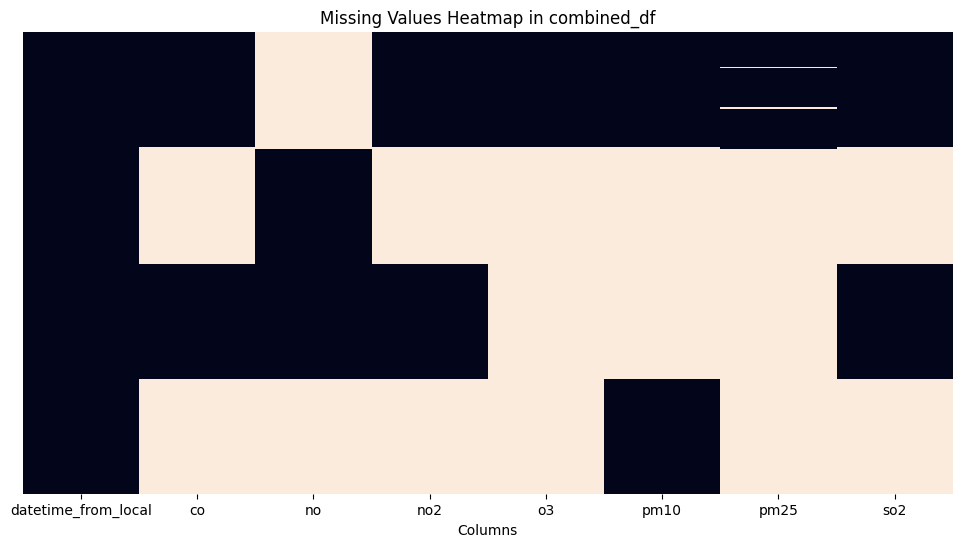

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_df.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in combined_df')
plt.xlabel('Columns')
plt.show()

In [ ]:
missing_percent = combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

parameter_name
pm25                   75.124378
o3                     75.124378
co                     50.248756
no                     50.248756
pm10                   50.248756
no2                    50.248756
so2                    50.248756
datetime_from_local     0.000000
dtype: float64


Due to the significant amount of missing data for all pollutants and considering there may be alternative ways to insert data through requests that I have not yet discovered after the first week of the open programme, I decided to download the available datasets for each month from each station for the year 2025. This will ensure that the data is more recent.

### AMS Chaika - Varna (part 2)

In [ ]:
chaika1 = pandas.read_csv('datasets/openaq_location_2162113_measurments.csv')
chaika1.shape

(3000, 15)

In [ ]:
chaika2 = pandas.read_csv('datasets/openaq_location_2162113_measurments (1).csv')
chaika2.shape

(1416, 15)

In [ ]:
chaika3 = pandas.read_csv('datasets/openaq_location_2162113_measurments (2).csv')
chaika3.shape

(1857, 15)

In [ ]:
chaika4 = pandas.read_csv('datasets/openaq_location_2162113_measurments (3).csv')
chaika4.shape

(1430, 15)

In [ ]:
chaika5 = pandas.read_csv('datasets/openaq_location_2162113_measurments (4).csv')
chaika5.shape

(1354, 15)

In [ ]:
chaika_dataset = pandas.concat([chaika1, chaika2, chaika3, chaika4, chaika5])

In [ ]:
chaika_dataset.shape

(9057, 15)

In [ ]:
chaika_dataset = chaika_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

chaika_dataset

parameter              datetimeLocal      co    no2    so2
0          2025-01-01T20:00:00+02:00  1450.0  26.41  20.61
1          2025-01-02T01:00:00+02:00  1260.0  22.42   9.25
2          2025-01-02T02:00:00+02:00  1040.0  16.81   8.45
3          2025-01-02T11:00:00+02:00   940.0  22.20  11.81
4          2025-01-02T12:00:00+02:00   960.0  21.99  13.28
...                              ...     ...    ...    ...
3045       2025-06-19T05:00:00+03:00   560.0  12.22  -1.00
3046       2025-06-19T06:00:00+03:00   560.0  12.20  -1.00
3047       2025-06-19T07:00:00+03:00   540.0   8.39  -1.00
3048       2025-06-19T09:00:00+03:00   540.0  11.03  -1.00
3049       2025-06-20T01:00:00+03:00   500.0   8.16  -1.00

[3050 rows x 4 columns]

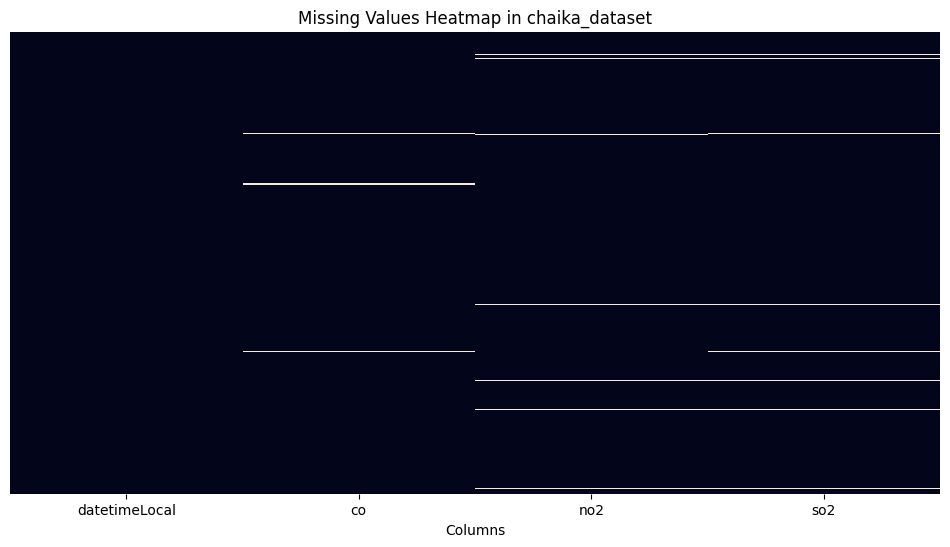

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(chaika_dataset.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in chaika_dataset')
plt.xlabel('Columns')
plt.show()

What is noticeable here is that although there is little data missing, not all pollutants from the previous dataset are present.

### Angel Kanchev-Varna (part 2)
Let's do the same here for the next station.

In [ ]:
angel1 = pandas.read_csv('datasets/openaq_location_8843_measurments.csv')
angel1.shape

(6000, 15)

In [ ]:
angel2 = pandas.read_csv('datasets/openaq_location_8843_measurments (1).csv')
angel2.shape

(2829, 15)

In [ ]:
angel3 = pandas.read_csv('datasets/openaq_location_8843_measurments (2).csv')
angel3.shape

(3727, 15)

In [ ]:
angel4 = pandas.read_csv('datasets/openaq_location_8843_measurments (3).csv')
angel4.shape

(2871, 15)

In [ ]:
angel5 = pandas.read_csv('datasets/openaq_location_8843_measurments (4).csv')
angel5.shape

(2724, 15)

In [ ]:
angel_dataset = pandas.concat([angel1, angel2, angel3, angel4, angel5])

In [ ]:
angel_dataset.shape

(18151, 15)

In [ ]:
angel_dataset = angel_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

angel_dataset

parameter              datetimeLocal      co     no2     o3   pm10   pm25  \
0          2025-01-01T20:00:00+02:00  1180.0   95.40   7.74  51.87  51.69   
1          2025-01-02T01:00:00+02:00   490.0   34.49  37.32  44.20  12.47   
2          2025-01-02T02:00:00+02:00   570.0   52.76  19.50  37.13  16.54   
3          2025-01-02T11:00:00+02:00   650.0   70.78  25.91  34.11  21.86   
4          2025-01-02T12:00:00+02:00   720.0   80.30  24.58  35.74  27.21   
...                              ...     ...     ...    ...    ...    ...   
3070       2025-06-19T05:00:00+03:00   350.0    7.46  50.75  10.97   5.82   
3071       2025-06-19T06:00:00+03:00   350.0    7.30  46.95   8.71   5.20   
3072       2025-06-19T07:00:00+03:00   330.0   15.55  41.18  12.10   5.40   
3073       2025-06-19T09:00:00+03:00   720.0  107.43   9.54  20.52   8.29   
3074       2025-06-20T01:00:00+03:00   370.0   46.84  31.60  25.07  12.71   

parameter    so2  
0          16.57  
1          16.00  
2          16.01  
3          16.45  
4          16.53  
...          ...  
3070       10.19  
3071       11.06  
3072       10.68  
3073       10.64  
3074       12.56  

[3075 rows x 7 columns]

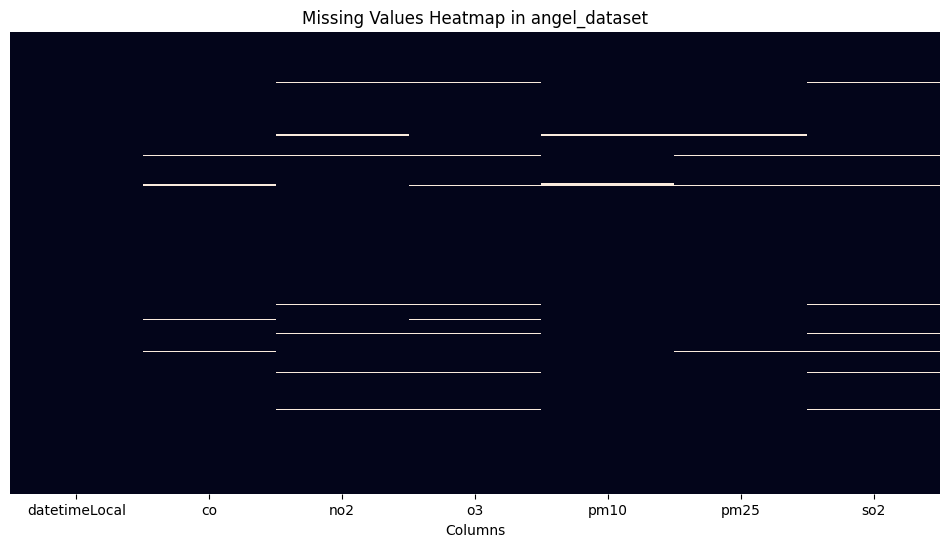

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(angel_dataset.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in angel_dataset')
plt.xlabel('Columns')
plt.show()

Compared to the previous dataset from Chaika, there are more pollutants, but some are still missing. 

Let's combine all of them to see the final result.

## Combination of all CSV files 📥

In [ ]:
final_combined_df = pandas.concat([chaika_dataset, angel_dataset, combined_df])

In [ ]:
print("The API key and csv file datasets contain: " + str(final_combined_df.shape))

The API key and csv file datasets contain: (6527, 9)


In [ ]:
final_combined_df.sample(10)

datetimeLocal      co    no2    so2     o3   pm10  pm25  \
2874  2025-06-06T07:00:00+03:00   600.0  12.22  -1.00    NaN    NaN   NaN   
2989  2025-06-13T20:00:00+03:00   490.0   6.94  -1.00    NaN    NaN   NaN   
2681  2025-05-26T04:00:00+03:00 -1000.0  -1.00  -1.00  -1.00  -1.00 -1.00   
2511  2025-05-17T10:00:00+03:00   470.0   8.84  -1.00    NaN    NaN   NaN   
394                         NaN     NaN    NaN    NaN    NaN  -1.00   NaN   
266   2025-01-18T03:00:00+02:00   570.0  15.24  17.33  43.54  17.66  9.94   
1765  2025-04-06T07:00:00+03:00   500.0   8.02   8.55    NaN    NaN   NaN   
2071  2025-04-20T13:00:00+03:00   640.0   9.84   9.60    NaN    NaN   NaN   
2044  2025-04-18T14:00:00+03:00   400.0   5.86  10.62  92.22  11.90  2.82   
2975  2025-06-12T15:00:00+03:00   510.0   6.97  -1.00    NaN    NaN   NaN   

            datetime_from_local  no  
2874                        NaN NaN  
2989                        NaN NaN  
2681                        NaN NaN  
2511                        NaN NaN  
394   2024-03-29T18:00:00+02:00 NaN  
266                         NaN NaN  
1765                        NaN NaN  
2071                        NaN NaN  
2044                        NaN NaN  
2975                        NaN NaN

## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the final key variables used in this dataset:

| No. | Column Name                 | Unit                  | Description                                                                 |
|-----|-----------------------------|-----------------------|-----------------------------------------------------------------------------|
| 1   | `co`                        | parts per million(ppm)| Concentration of carbon monoxide (CO).                                      |
| 2   | `no2`                       | µg/m³                 | Concentration of nitrogen dioxide (NO₂).                                    |
| 3   | `so2`                       | µg/m³                 | Concentration of sulfur dioxide (SO₂).                                      |
| 4   | `o3`                        | µg/m³                 | Concentration of ozone (O₃).                                                |
| 5   | `pm10`                      | µg/m³                 | Concentration of particulate matter (PM₁₀).                                 |
| 6   | `pm25`                      | µg/m³                 | Concentration of particulate matter (PM₂.₅).                                |
| 7   | `no`                        | µg/m³                 | Concentration of nitrogen monoxide (NO).                                    |
| 8   | `datetimeLocal/datetime_from_local` | datetime      | Local date and time of the measurement.                                     |
| 9   | `AQI`                       | unitless              | Air Quality Index (AQI) value calculated based on pollutant concentrations. |
| 10  | `AQI_Category`              | categorical           | Qualitative category of air quality based on AQI values.                    |

⚠️ Not all variables were used in the final model. Several columns were excluded during the cleaning and feature selection process due to missing values, low variance, or low correlation with the target variable (see EDA section for justification).

## Preprocessing 🛠️

### Format dates 🗓️

It is evident that the columns "datetimeLocal" and "datetime_from_local" cannot co-exist since they represent the same data. Therefore, it is logical to combine them into a single column.

In [ ]:
final_combined_df['datetime_local'] = final_combined_df['datetime_from_local'].combine_first(final_combined_df['datetimeLocal'])
final_combined_df.drop(columns=['datetime_from_local', 'datetimeLocal'], inplace=True)

In [ ]:
final_combined_df.dtypes

co                float64
no2               float64
so2               float64
o3                float64
pm10              float64
pm25              float64
no                float64
datetime_local     object
dtype: object

In [ ]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], utc=True)
print(final_combined_df.dtypes)

co                            float64
no2                           float64
so2                           float64
o3                            float64
pm10                          float64
pm25                          float64
no                            float64
datetime_local    datetime64[ns, UTC]
dtype: object


In [ ]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], errors='coerce')
final_combined_df['datetime_local'] = final_combined_df['datetime_local'].dt.strftime('%Y-%m-%d %H:%M')

In [ ]:
final_combined_df.sample(10)

co    no2    so2      o3   pm10   pm25    no    datetime_local
2890  240.0  16.15  13.13  135.26  16.01  12.74   NaN  2025-06-05 17:00
16    460.0  19.75  16.26   47.23  33.78  19.21   NaN  2025-01-02 22:00
2005  430.0  20.21   9.11  112.68   8.17   6.74   NaN  2025-04-16 19:00
644   550.0  11.01   6.96     NaN    NaN    NaN   NaN  2025-02-05 17:00
65    280.0  38.90  19.99   25.70  31.33   0.05   NaN  2020-04-24 02:00
1954  460.0   7.62  10.49   97.53  19.78   6.10   NaN  2025-04-14 11:00
2991  510.0  23.28  10.11   54.65  45.08  17.41   NaN  2025-06-12 05:00
2472  870.0  91.13   5.00    8.80  38.84  37.64   NaN  2025-05-14 07:00
204   310.0  14.02   8.53     NaN    NaN    NaN  1.54  2024-01-29 00:00
418   470.0   7.62  17.48   43.08  14.54   9.36   NaN  2025-01-25 06:00

### Null values 0️⃣

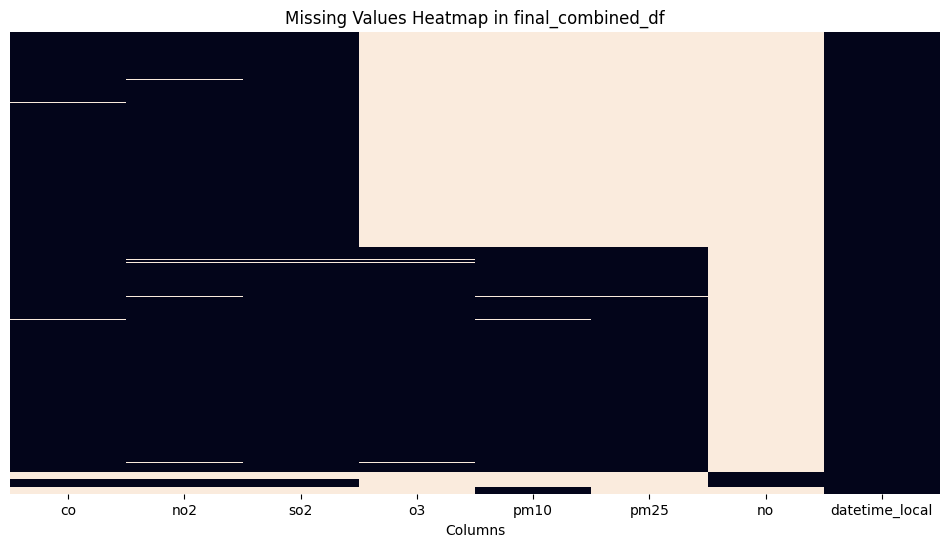

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [ ]:
missing_percent = final_combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

no                96.935805
o3                52.290486
pm25              52.014708
pm10              50.375364
no2                4.703539
so2                4.473725
co                 3.968132
datetime_local     0.000000
dtype: float64


Since **nitric oxide (NO)** is missing in nearly 97% of the dataset, I believe it is not very important and should not be included. I will only retain values that have a presence of more than 30% in the dataset, as those have a valid reason for being kept. Even partial data can capture trends or patterns.

To better understand each value, I will explain them one by one, chemical by chemical:

**PM2.5 (Fine Particulate Matter)**
- One of the most dangerous air pollutants. Often a major driver of AQI values.
- Can penetrate deep into the lungs and even enter the bloodstream. Linked to respiratory and cardiovascular diseases, premature death and cancer.

**PM10 (Inhalable Particulate Matter)**
- Can cause respiratory irritation, lung function decline and worsen conditions like asthma and bronchitis.

**O₃ (Ground-level Ozone)**
- Not emitted directly; formed by chemical reactions between NOx and VOCs in sunlight.
- Causes chest pain, coughing, throat irritation, and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, can be fatal at very high levels; particularly dangerous indoors.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO₂ (Nitrogen Dioxide)**
- Combustion engines (cars, trucks, etc), power plants.
- Irritates airways, reduces lung function, and increases the risk of respiratory infections.
- Key indicator of traffic-related air pollution; contributes to the formation of PM and ozone.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Less directly harmful, but quickly converts into **NO₂**, which is more dangerous.

So since we have enough of the **NO₂**, discarding **NO** is fine, due to the following reasons:
- **NO** and **NO₂** are chemically linked and often reported together as NOx (nitrogen oxides).
- **NO₂** is the more harmful and relevant pollutant for health and AQI. It is usually used directly in AQI calculation, not **NO**.
- **NO** is a precursor to **NO₂** and ozone, but if you already have **NO₂** (which reflects both traffic-related emissions and photochemical activity), we are already capturing the more critical part of the picture.

sources: 
- https://ww2.arb.ca.gov/resources/nitrogen-dioxide-and-health#:~:text=Air%20quality%20regulators%20have%20selected,X%20emissions%20as%20a%20group
- https://en.wikipedia.org/wiki/NOx#:~:text=In%20atmospheric%20chemistry%2C%20the%20term,to%20again%20form%20NO%202

In [ ]:
threshold = 0.7
final_combined_df = final_combined_df.loc[:, final_combined_df.isnull().mean() < threshold]

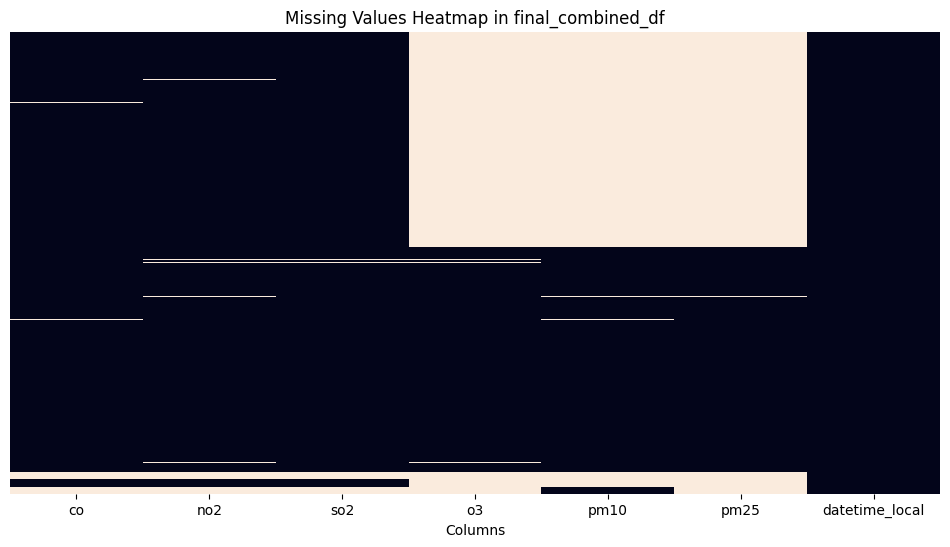

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [ ]:
final_combined_df.sample(10)

co    no2    so2     o3   pm10  pm25    datetime_local
2178   440.0   7.00   9.84    NaN    NaN   NaN  2025-04-27 03:00
1000   540.0   8.51   7.35    NaN    NaN   NaN  2025-02-21 23:00
2353   330.0   4.62   4.22  52.16  10.58  5.57  2025-05-08 22:00
50     460.0  22.99  15.59  38.83   5.99  3.47  2025-01-04 09:00
1004   440.0   6.88  20.07  71.65   9.28  4.68  2025-02-21 13:00
1126   920.0  16.60   7.31    NaN    NaN   NaN  2025-03-06 02:00
250  -1000.0  -1.00  -1.00  -1.00  -1.00 -1.00  2025-01-17 08:00
2611   470.0  11.07  -1.00    NaN    NaN   NaN  2025-05-23 20:00
1860   400.0   7.00   8.33    NaN    NaN   NaN  2025-04-11 01:00
124      NaN    NaN    NaN    NaN    NaN   NaN  2023-03-30 15:00

Since several key features like **O₃**, **PM2.5** and **PM10** have more than 50% missing values, we apply mean imputation to handle missing values in key pollutant features, ensuring dataset completeness while preserving the overall data distribution for model training.

In [ ]:
# imputer = SimpleImputer(strategy='mean') 
# final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']] = imputer.fit_transform(
#     final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']]
# )

After testing the models, I found overfitting due to imputation. To prevent this, I decided to drop the non-value data instead. That is why I commented the block of code.

In [ ]:
final_combined_df = final_combined_df.dropna(subset=['co', 'no2', 'so2', 'o3', 'pm10', 'pm25'])

In [ ]:
final_combined_df.isnull().sum()

co                0
no2               0
so2               0
o3                0
pm10              0
pm25              0
datetime_local    0
dtype: int64

Finally, here is the result no missing values.

The issue with the missing data arises from the outdated measurments provided by the API key, as well as the fact that both stations do not collect the same measurements. To address this, I utilized the CSV files. The data for 2025 is much more complete and up-to-date, making it a better choice for the model and the final results.

## Sample the data 📃

In [ ]:
final_combined_df.sample(10)

co    no2    so2     o3   pm10   pm25    datetime_local
268   490.0  17.50  16.75  40.43  16.96  11.58  2025-01-18 03:00
2934  310.0  21.97  10.07  80.98  48.05   9.37  2025-06-09 09:00
2757  430.0  63.53   9.86  37.61  26.65  13.57  2025-05-29 20:00
2608  400.0  29.42  10.16  91.57  19.38  15.38  2025-05-22 18:00
177   610.0  65.58  15.89  12.02  44.51  15.85  2025-01-09 22:00
1094  530.0  32.28  10.74  66.24  22.01  11.24  2025-02-28 17:00
767   440.0  10.37  18.27  56.69  21.25   7.19  2025-02-10 12:00
2798  280.0   2.87   9.64  82.53   8.86   7.54  2025-05-31 18:00
1314  570.0  50.11  11.01   9.84  51.10  17.63  2025-03-14 06:00
2796  270.0   3.04  11.88  83.53   8.45   7.23  2025-05-31 16:00

## Calculating AQI 🧮
At the moment there is no present target variable from this data, however the data is enough to calculate the AQI sub-index for a given pollutant concentration, based on a list of breakpoint ranges. Then, it rounds the result to the nearest whole number (since AQI is usually reported as an integer). If no breakpoint matches, it returns None

In [ ]:
def get_subindex(concentration, breakpoints):
    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= concentration <= Chigh:
            return round((Ihigh - Ilow) / (Chigh - Clow) * (concentration - Clow) + Ilow)
    return None

The following block defines breakpoints for the air pollutants. These are used to map pollutant concentration levels to AQI sub-index values, according to air quality standards. 

Each list of breakpoints contains tuples with 4 values:

**(Concentration_low, Concentration_high, AQI_low, AQI_high)**

These represent a range of pollutant concentration values and the corresponding AQI values.

I got it from United States Environmental Protection Agency (https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [ ]:
pm25_breakpoints = [
    (0.0, 9.0, 0, 50),             # Good
    (9.1, 35.4, 51, 100),          # Moderate
    (35.5, 55.4, 101, 150),        # Unhealthy for sensitive groups
    (55.5, 125.4, 151, 200),       # Unhealthy
    (125.5, 225.4, 201, 300),      # Very Unhealthy
    (225.5, 325.4, 301, 400),      # Hazardous
    (325.5, 99999.9, 401, 500)     # Extended Hazardous
]
pm10_breakpoints = [
    (0, 54, 0, 50),                # Good
    (55, 154, 51, 100),            # Moderate
    (155, 254, 101, 150),          # Unhealthy for sensitive groups
    (255, 354, 151, 200),          # Unhealthy
    (355, 424, 201, 300),          # Very Unhealthy
    (425, 604, 301, 500),          # Hazardous
    (605, 99999.9, 501, 999)       # Extended Hazardous
]
o3_breakpoints = [      
    (0, 54, 0, 50),                # Good    
    (55, 70, 51, 100),             # Moderate    
    (71, 85, 101, 150),            # Unhealthy for sensitive groups  
    (86, 105, 151, 200),           # Unhealthy
    (106, 200, 201, 300)           # Very Unhealthy
]
co_breakpoints = [
    (0.0, 4.4, 0, 50),             # Good
    (4.5, 9.4, 51, 100),           # Moderate
    (9.5, 12.4, 101, 150),         # Unhealthy for sensitive groups
    (12.5, 15.4, 151, 200),        # Unhealthy
    (15.5, 30.4, 201, 300),        # Very Unhealthy
    (30.5, 50.4, 301, 500),        # Hazardous
    (50.5, 99999.9, 501, 999)      # Extended Hazardous
]
no2_breakpoints = [
    (0, 53, 0, 50),                # Good
    (54, 100, 51, 100),            # Moderate
    (101, 360, 101, 150),          # Unhealthy for sensitive groups
    (361, 649, 151, 200),          # Unhealthy
    (650, 1249, 201, 300),         # Very Unhealthy
    (1250, 2049, 301, 500),        # Hazardous
    (2050, 99999, 501, 999)        # Extended Hazardous
]
so2_breakpoints = [
    (0, 35, 0, 50),                # Good
    (36, 75, 51, 100),             # Moderate
    (76, 185, 101, 150),           # Unhealthy for sensitive groups
    (186, 304, 151, 200),          # Unhealthy
    (305, 99999, 201, 300)         # Very Unhealthy
]

To quantify overall air quality, we calculate the AQI for each row based on six key pollutants: PM2.5, PM10, O₃, CO, NO₂ and SO₂. For each pollutant, we compute a sub-index AQI using EPA-defined breakpoints and a standard formula that linearly maps pollutant concentrations to the AQI scale. 

CO concentrations are converted from µg/m³ to mg/m³ to match the units of its breakpoints. 

Only non-missing pollutant values are considered and the final AQI for each row is determined by taking the maximum of the available sub-indices, reflecting the pollutant posing the greatest health risk at that point in time. This process results in a single AQI value per observation, representing the overall air quality based on the most harmful pollutant present.

In [ ]:
def calculate_row_aqi(row):
    aqi_values = []
    
    if not pandas.isnull(row['pm25']):
        aqi_values.append(get_subindex(row['pm25'], pm25_breakpoints))
    if not pandas.isnull(row['pm10']):
        aqi_values.append(get_subindex(row['pm10'], pm10_breakpoints))
    if not pandas.isnull(row['o3']):
        aqi_values.append(get_subindex(row['o3'], o3_breakpoints))
    if not pandas.isnull(row['co']):
        aqi_values.append(get_subindex(row['co'] / 1000, co_breakpoints))  # µg/m³ to mg/m³
    if not pandas.isnull(row['no2']):
        aqi_values.append(get_subindex(row['no2'], no2_breakpoints))
    if not pandas.isnull(row['so2']):
        aqi_values.append(get_subindex(row['so2'], so2_breakpoints))
    
    return max([aqi for aqi in aqi_values if aqi is not None], default=None)

final_combined_df['AQI'] = final_combined_df.apply(calculate_row_aqi, axis=1)

To make the AQI values more interpretable, we classify them into standard health-related categories using this function, which assigns each AQI to a label based on U.S. EPA guidelines (https://www3.epa.gov/ttn/ozonehealth/figure14.html).

The result is stored in a new column called "AQI_Category", making it easy to group and visualize air quality conditions across different records.

In [ ]:
def aqi_category(aqi):
    if aqi is None:
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

final_combined_df['AQI_Category'] = final_combined_df['AQI'].apply(aqi_category)

In [ ]:
final_combined_df['AQI_Category'].value_counts()

AQI_Category
Moderate                          1492
Unhealthy for Sensitive Groups     556
Good                               497
Unhealthy                          327
Hazardous                          152
Very Unhealthy                      57
Name: count, dtype: int64

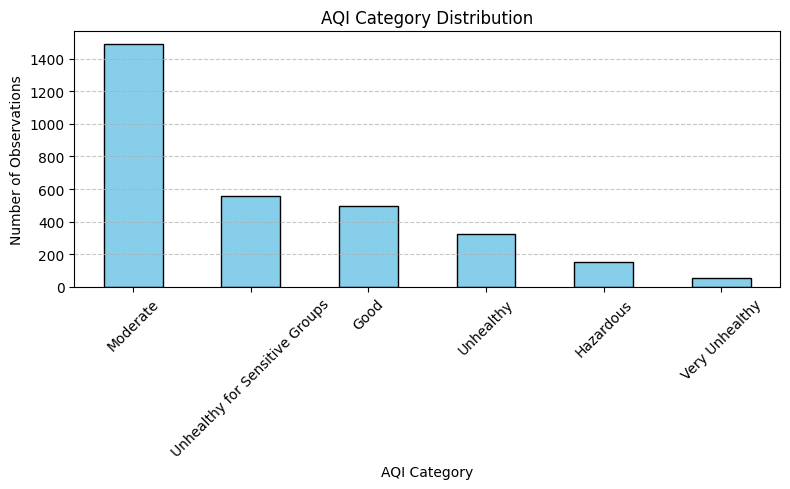

In [ ]:
category_counts = final_combined_df['AQI_Category'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The "Moderate" AQI category has the highest number of observations, which is a common outcome in urban air quality datasets. This reflects typical, day-to-day air conditions where pollutant levels are elevated due to vehicle traffic, household activities and mild industrial emissions, but not high enough to trigger health warnings for the general population. In many environments, especially outside of extreme weather events or major pollution incidents, air quality tends to fluctuate within this moderate range. This suggests that while the air may not be perfectly clean, it is generally acceptable for most people, with only limited risk for sensitive individuals.

In [ ]:
final_combined_df.isnull().sum()

co                  0
no2                 0
so2                 0
o3                  0
pm10                0
pm25                0
datetime_local      0
AQI               152
AQI_Category        0
dtype: int64

In [ ]:
final_combined_df = final_combined_df.dropna(subset=['AQI'])

In [ ]:
final_combined_df.sample(10)

co     no2    so2     o3   pm10   pm25    datetime_local    AQI  \
1398  290.0    2.76  12.81  48.46   4.39   1.13  2025-03-18 04:00   45.0   
1200  930.0  121.53  14.46  18.72  44.61  34.00  2025-03-08 19:00  105.0   
671   430.0    4.40  18.77  39.69   9.88   4.71  2025-02-06 08:00   37.0   
2119  460.0   23.36  11.16  77.84  17.11   5.67  2025-04-21 23:00  125.0   
339   530.0   45.58  16.12  40.54  50.73  11.23  2025-01-21 12:00   55.0   
144   480.0   49.06  20.94  37.32  17.16   8.51  2025-01-08 10:00   47.0   
3061  270.0    5.09  14.09  79.45  13.59   7.97  2025-06-18 14:00  131.0   
2145  480.0   39.14  10.76  58.98  19.42  11.68  2025-04-24 07:00   64.0   
1332  470.0   28.34  11.00  27.88  35.91  10.92  2025-03-15 04:00   54.0   
2789  300.0    4.08   8.25  62.75  12.54   4.05  2025-05-31 08:00   76.0   

                        AQI_Category  
1398                            Good  
1200  Unhealthy for Sensitive Groups  
671                             Good  
2119  Unhealthy for Sensitive Groups  
339                         Moderate  
144                             Good  
3061  Unhealthy for Sensitive Groups  
2145                        Moderate  
1332                        Moderate  
2789                        Moderate

## Data Analysis and Visualization 📊

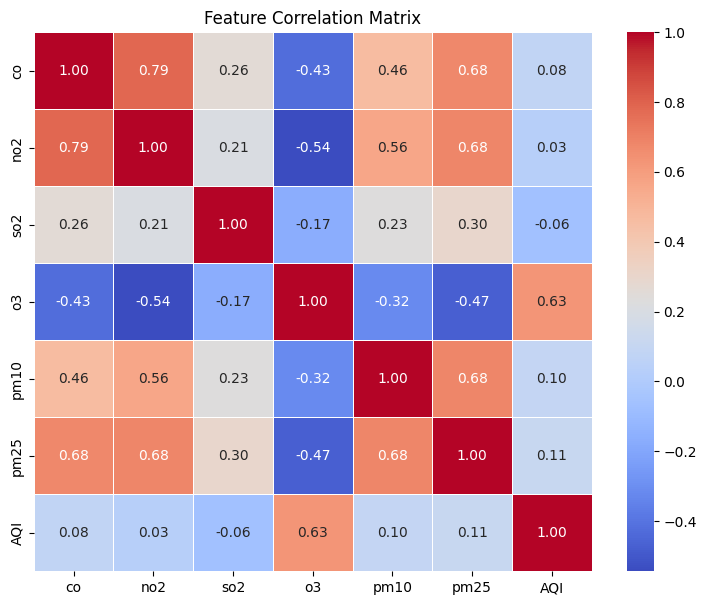

In [ ]:
numeric_df = final_combined_df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(9, 7))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Feature Correlation Matrix')
plt.show()

This is a correlation matrix heatmap showing the relationships between various air quality features: carbon monoxide (co), nitrogen dioxide (no2), sulfur dioxide (so2), ozone (o3), particulate matter ≤10μm (pm10), particulate matter ≤2.5μm (pm25) and the Air Quality Index (AQI). Each cell contains the Pearson correlation coefficient between two features, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). Red shades indicate strong positive correlations, blue shades indicate strong negative correlations and neutral colors show weak or no correlation.

**Key observations:**
- co and no2 have a strong positive correlation (0.79), meaning they tend to increase or decrease together.
- pm10 and pm25 are also strongly positively correlated (0.68), reflecting their similar sources and behavior.
- o3 is negatively correlated with no2 (-0.54) and pm25 (-0.47), indicating that as ozone increases, these pollutants tend to decrease.
- AQI has a moderate positive correlation with o3 (0.63), suggesting ozone levels significantly influence air quality in this dataset.
- Other correlations, such as AQI with co, no2, so2, pm10 and pm25, are weak (close to zero).

This matrix helps identify which pollutants are closely related, which can inform air quality analysis and modeling.

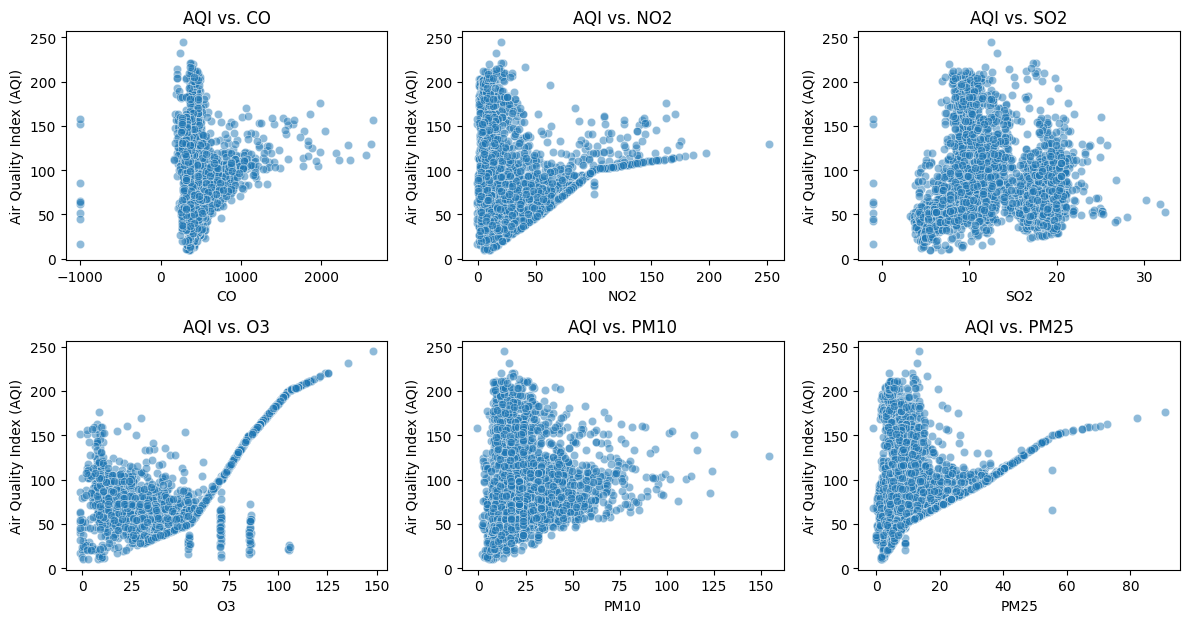

In [ ]:
air_quality_features = ["co", "no2", "so2", "o3", "pm10", "pm25"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axes = axes.flatten()

for i, feature in enumerate(air_quality_features):
    seaborn.scatterplot(
        x=final_combined_df[feature],
        y=final_combined_df["AQI"], 
        alpha=0.5,
        ax=axes[i] 
    )
    axes[i].set_xlabel(feature.upper())
    axes[i].set_ylabel("Air Quality Index (AQI)")
    axes[i].set_title(f"AQI vs. {feature.upper()}")

for j in range(len(air_quality_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

These scatter plots show the relationship between the Air Quality Index (AQI) and six air pollutants: carbon monoxide (CO), nitrogen dioxide (NO2), sulfur dioxide (SO2), ozone (O3), particulate matter ≤10μm (PM10) and particulate matter ≤2.5μm (PM25). Each point represents a data sample, with the pollutant concentration on the x-axis and the AQI value on the y-axis.

**Key observations:**
- CO (Carbon Monoxide): The points are widely scattered and form a triangular pattern, suggesting there is no strong or consistent relationship between CO levels and AQI in this dataset.
- NO2 (Nitrogen Dioxide): Similar to CO, the data points are spread out in a triangular shape, indicating only a weak or inconsistent relationship between NO2 and AQI.
- SO2 (Sulfur Dioxide): The points are clustered without a clear trend, showing little to no direct relationship between SO2 and AQI.
- O3 (Ozone): There is a noticeable upward trend, especially at higher ozone levels. As O3 increases, AQI also tends to increase, indicating a stronger positive relationship compared to the other pollutants.
- PM10 (Particulate Matter ≤10μm): The scatter is wide and triangular, showing a weak relationship between PM10 and AQI.
- PM25 (Particulate Matter ≤2.5μm): The pattern is similar to PM10, with a wide spread of AQI values for most PM25 concentrations, indicating a weak relationship.

Overall, these plots indicate that among the pollutants shown, ozone (O3) has the strongest visible association with AQI, while the others show weaker or less clear relationships. This suggests that, in this dataset, AQI is most sensitive to changes in ozone levels.

## Target variable 🎯

In [ ]:
features = ['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']
target = 'AQI'

X = final_combined_df[features]
y = final_combined_df[target]

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 2929 observations, of which 2343 are now in the train set and 586 in the test set.


## Modelling 🧬

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LGBM': LGBMRegressor(force_col_wise=True, verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append((name, mae, mse, r2))

results_df = pandas.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'R²'])
results_df = results_df.sort_values('MAE')

results_df

Model        MAE          MSE        R²
1       Random Forest   0.939283    10.873438  0.994438
5             Bagging   1.022867    10.869078  0.994440
4         Extra Trees   2.009096    34.868036  0.982164
2             XGBoost   2.861790    91.604010  0.953142
10               LGBM   2.930470    68.514247  0.964953
11           CatBoost   3.133157    64.143346  0.967189
3   Gradient Boosting   3.290149    53.080957  0.972848
7                 KNN  10.268259   306.407782  0.843264
0   Linear Regression  20.455841   647.977642  0.668541
8               Ridge  20.455850   647.977804  0.668541
9               Lasso  20.478284   648.544294  0.668251
6                 SVR  29.018499  1694.639428  0.133144

**Best Models**: 
- **Random Forest**: Top performer with the lowest MAE and MSE and highest R².
- **Bagging** and **Extra Trees**: Close contenders with excellent accuracy.

**Intermediate Models**: 
- **XGBoost**, **LGBM** and **CatBoost**: Reasonable performance, but slightly higher errors compared to top models.

**Underperformers**: 
- **KNN**: Moderate performance with significant errors.
- **Linear Models (Linear Regression, Ridge, Lasso)**: Poor fit for this dataset, unable to capture non-linear patterns.
- **SVR**: Worst performer with very high errors and low R².

Random Forest will be used for optimal accuracy, balancing computational efficiency and performance.


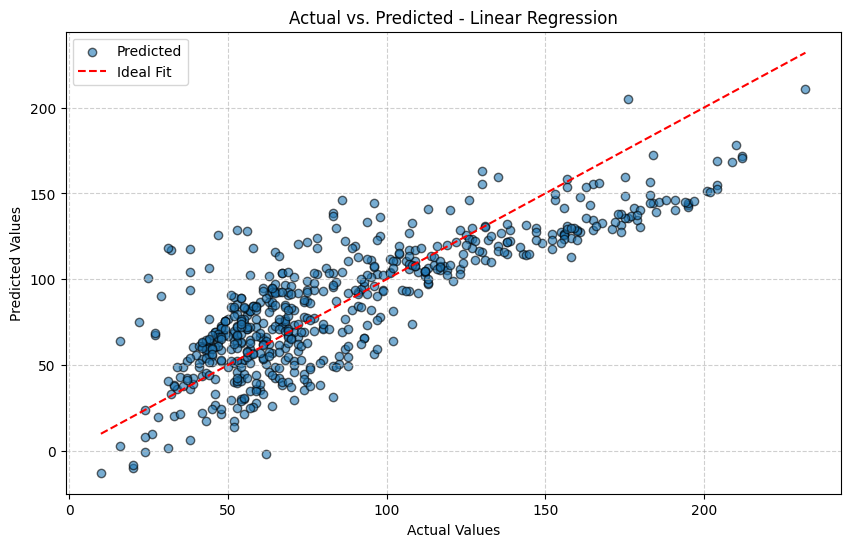

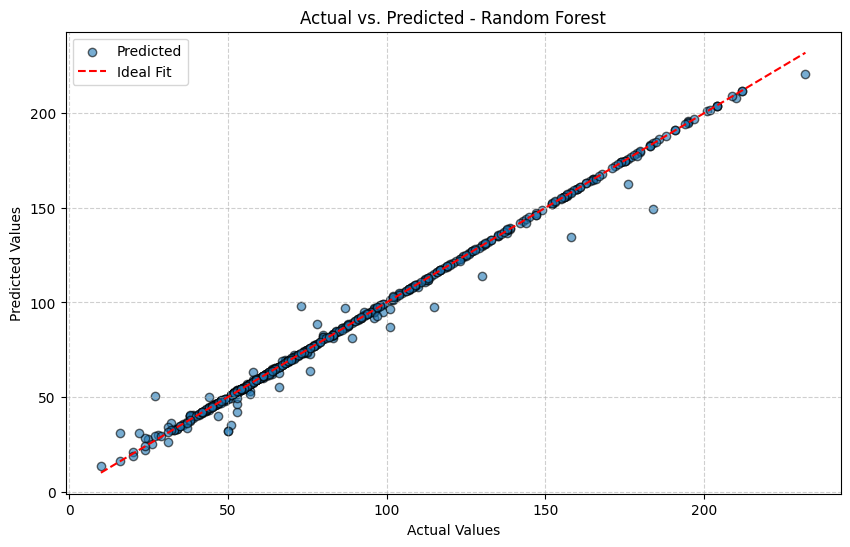

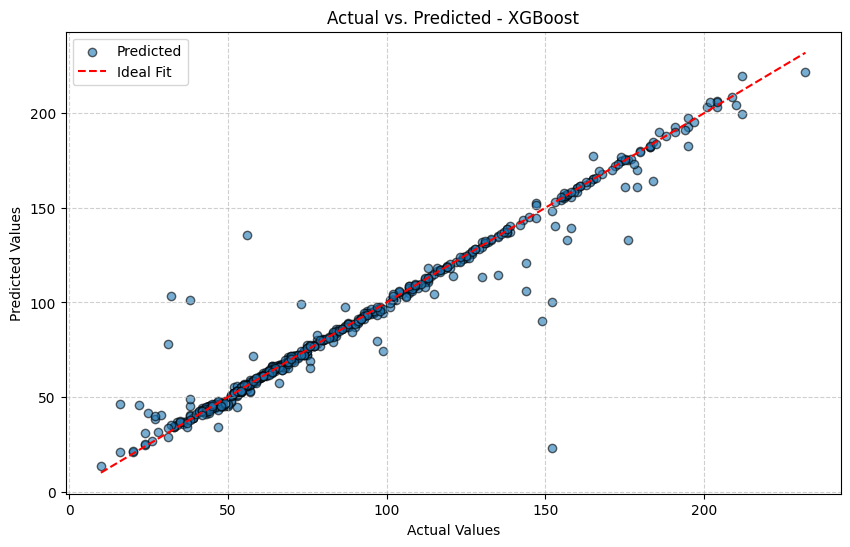

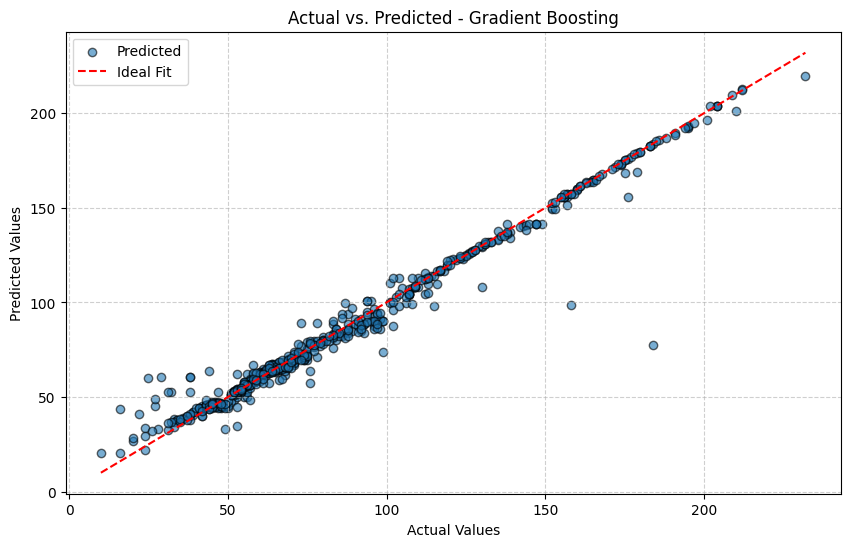

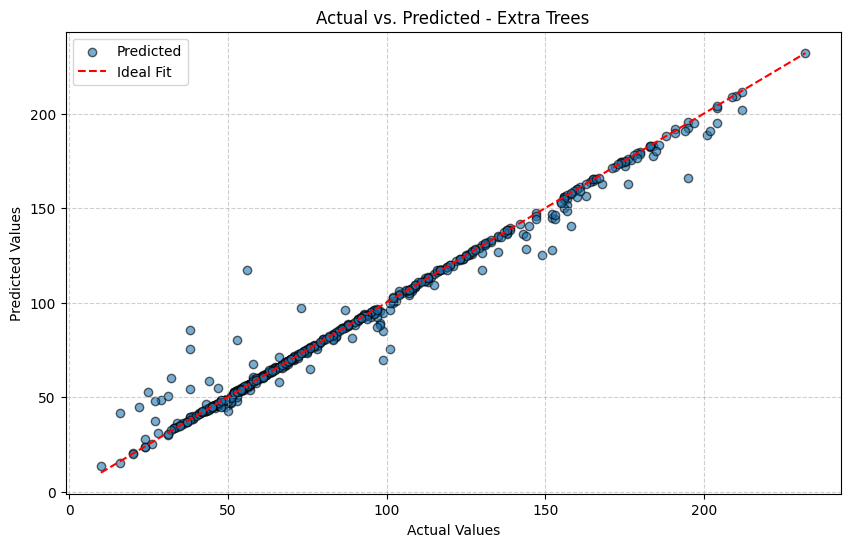

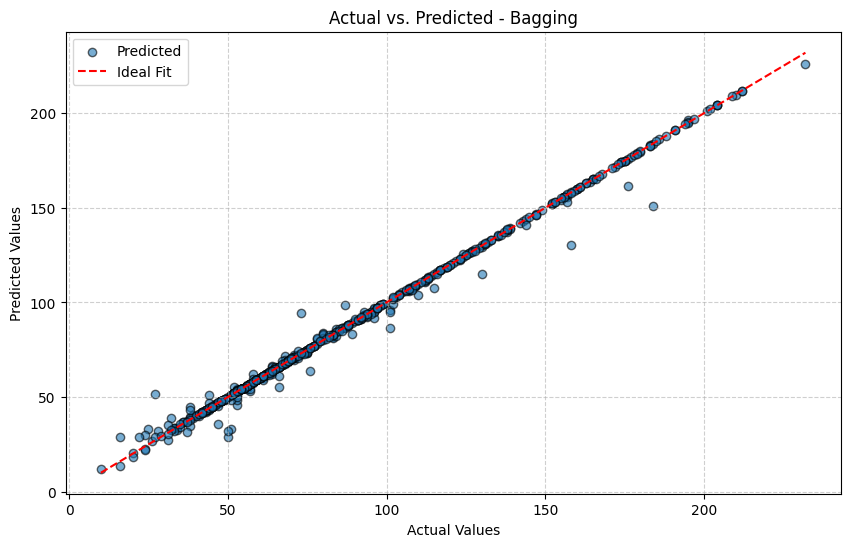

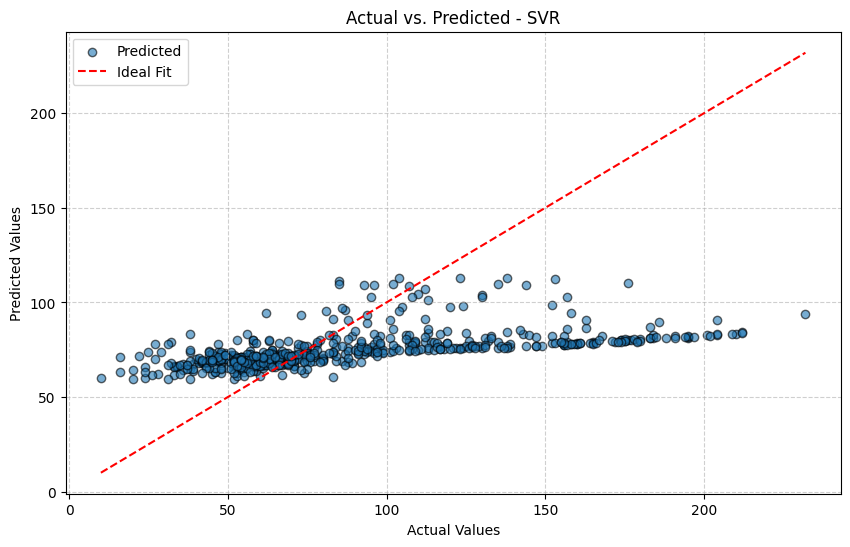

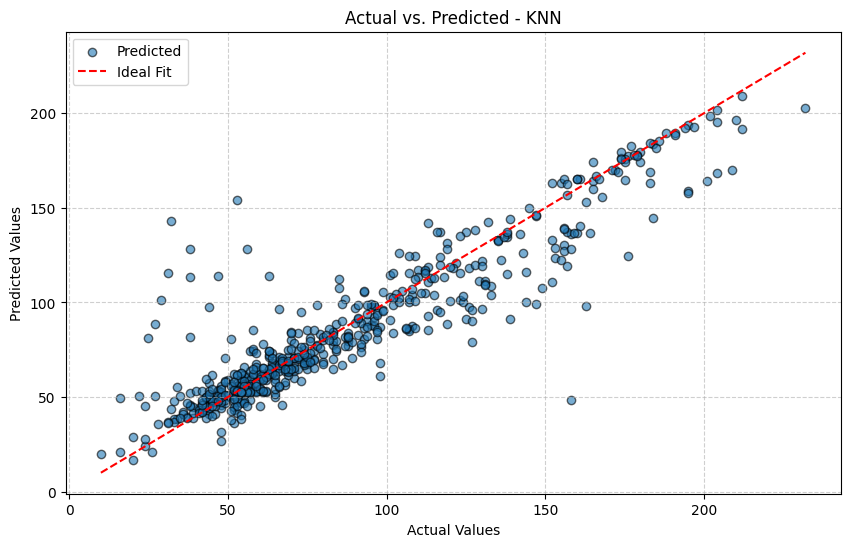

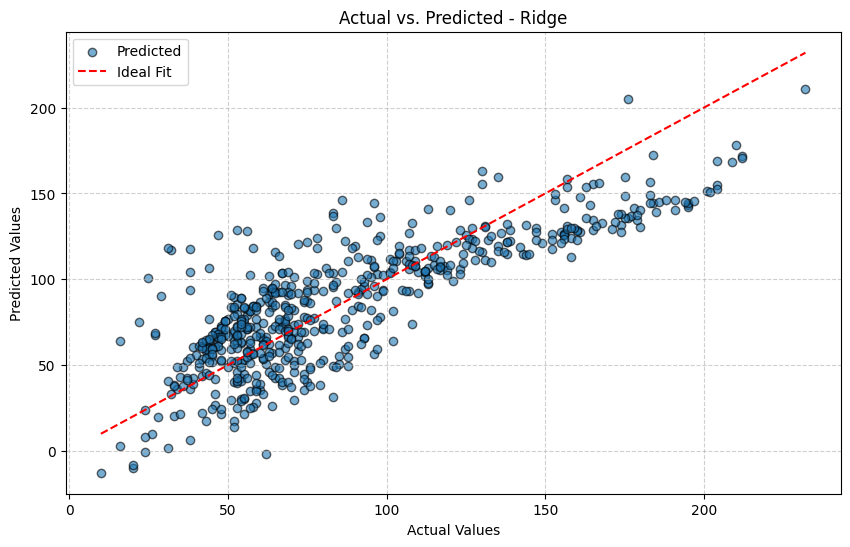

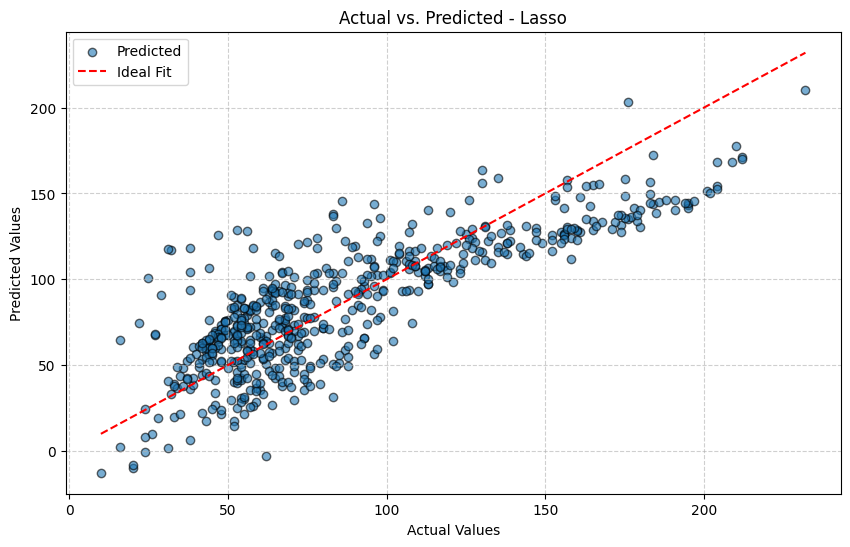

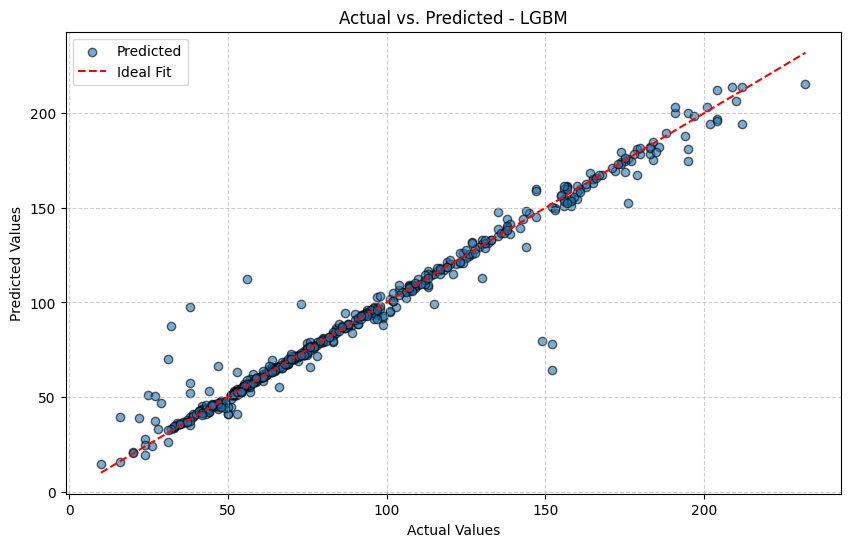

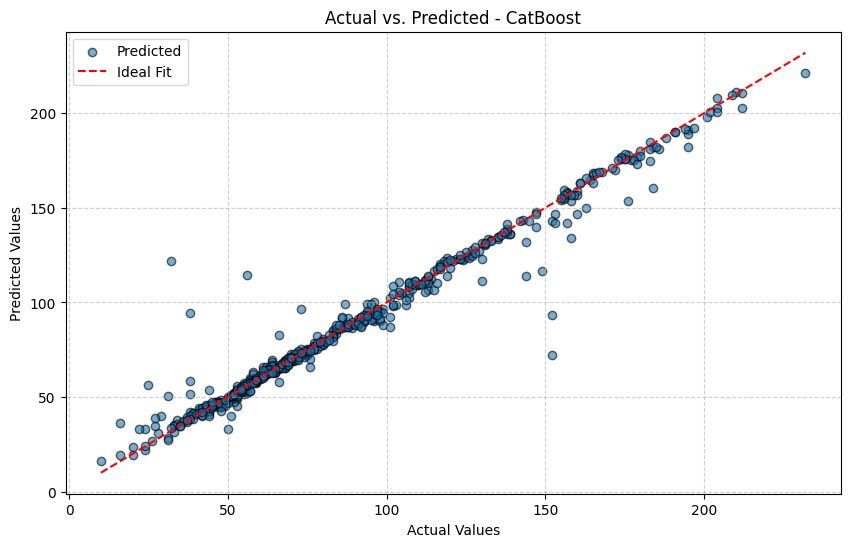

In [ ]:
for name, model in models.items():
    preds = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.6, edgecolor='k', label='Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
    plt.title(f"Actual vs. Predicted - {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

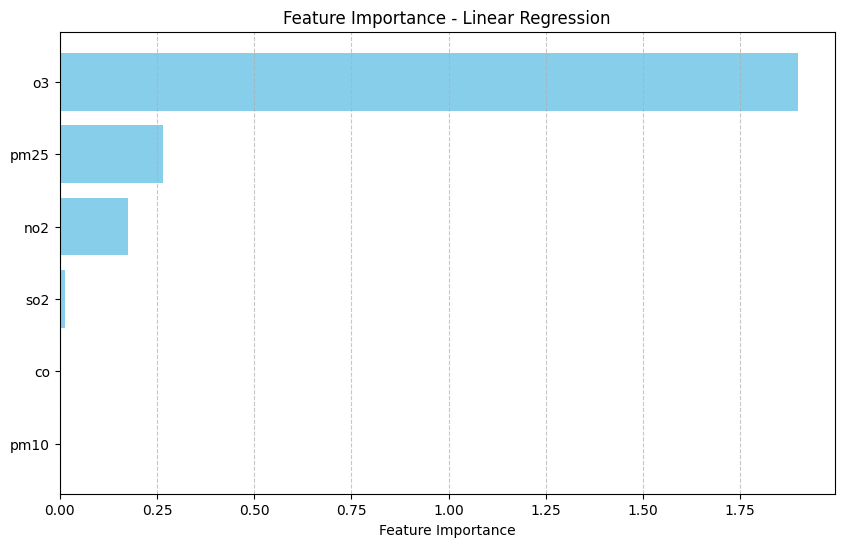

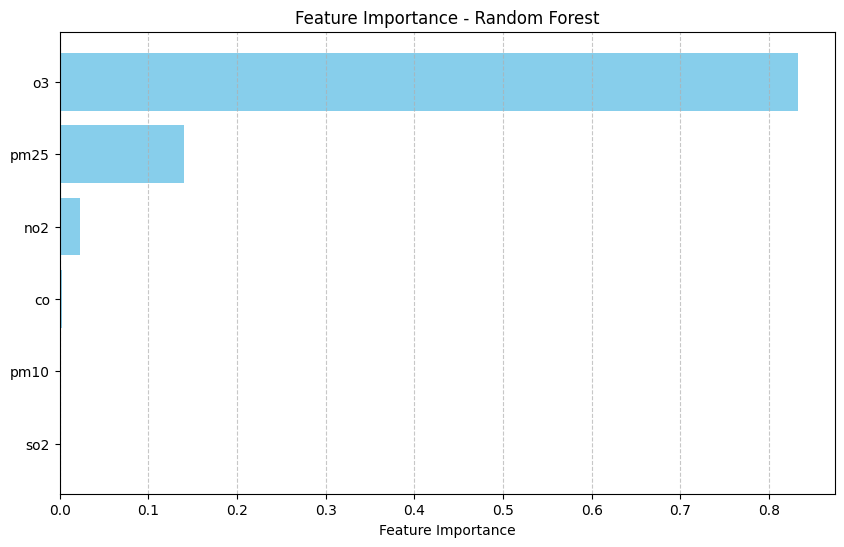

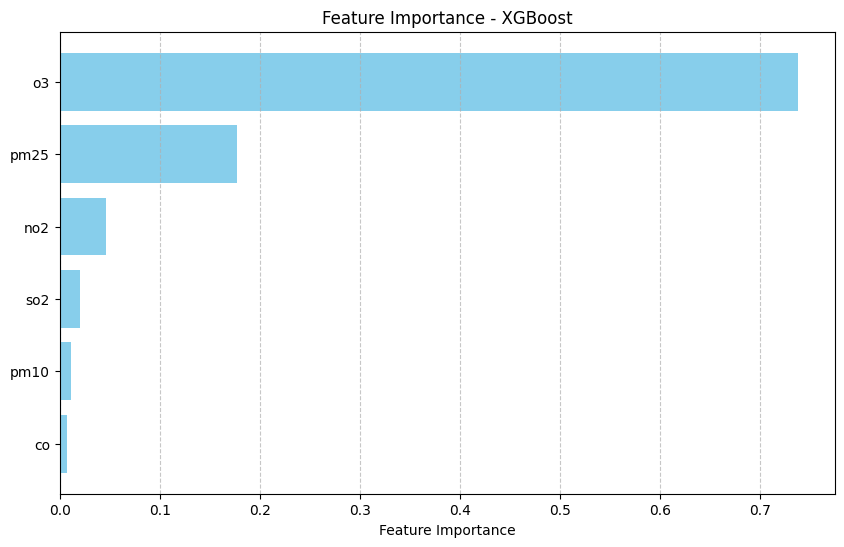

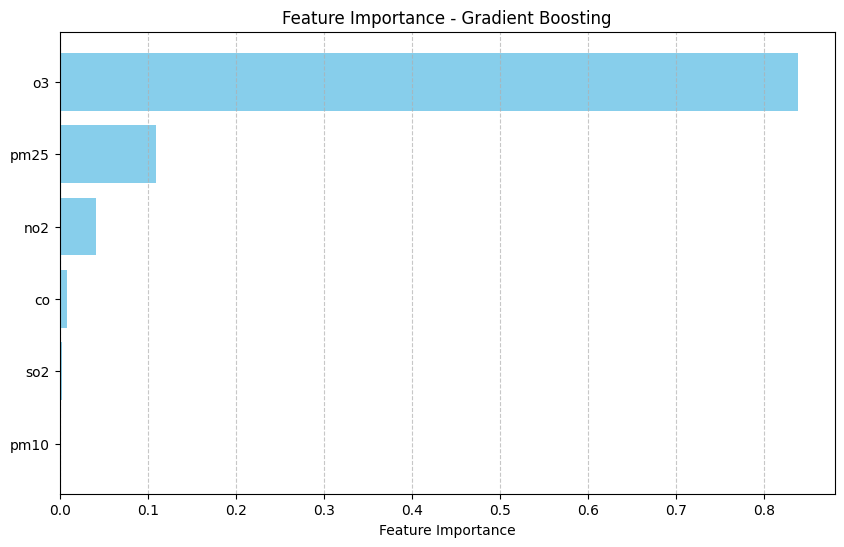

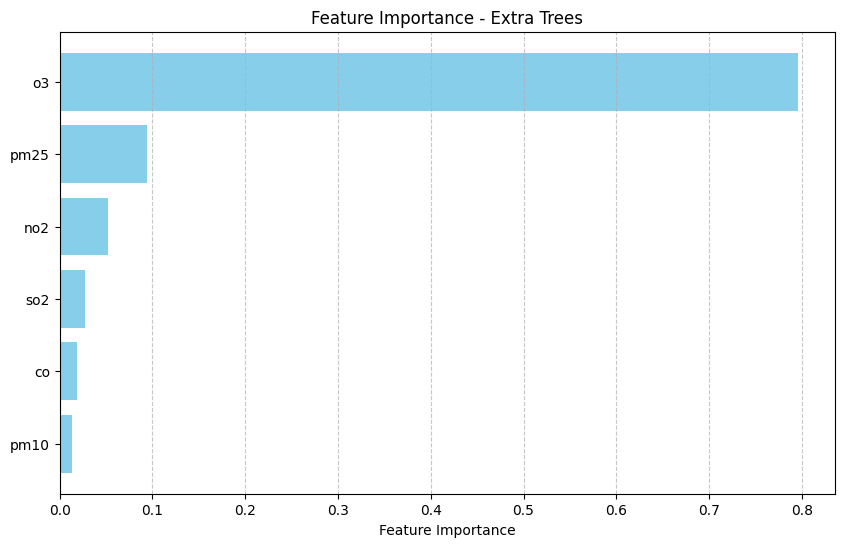

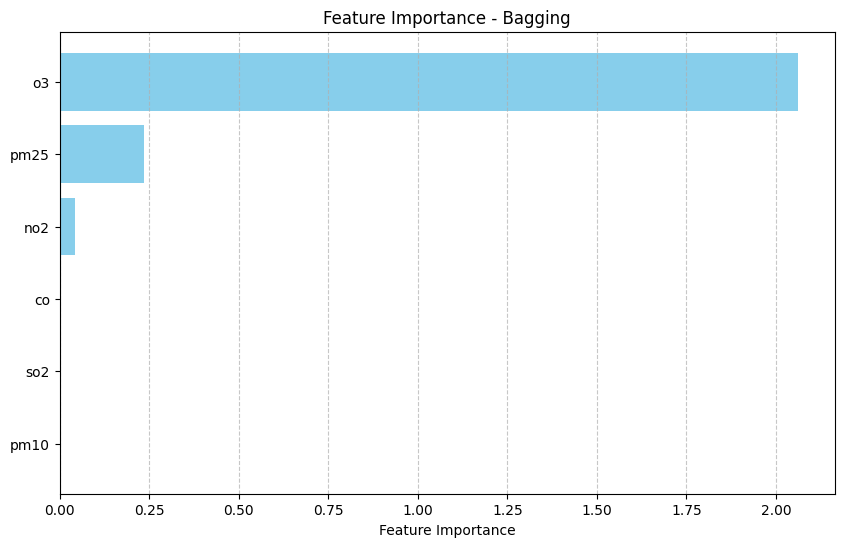

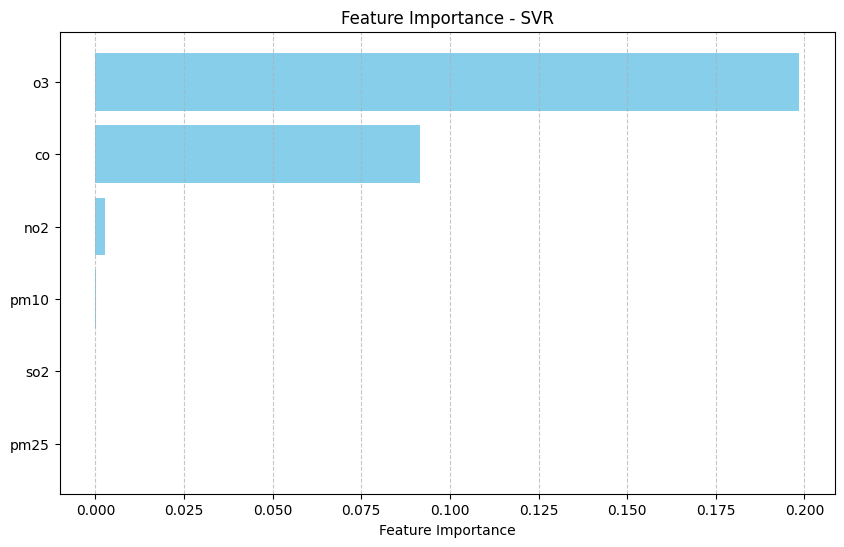

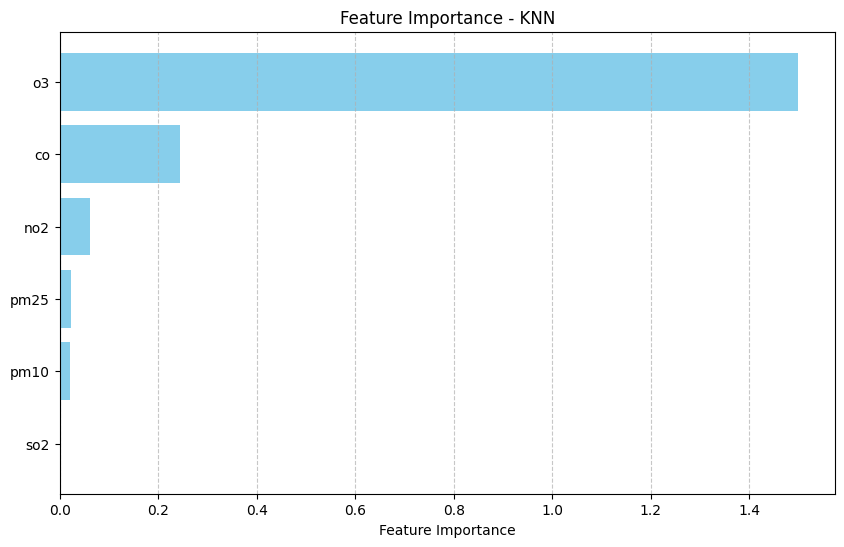

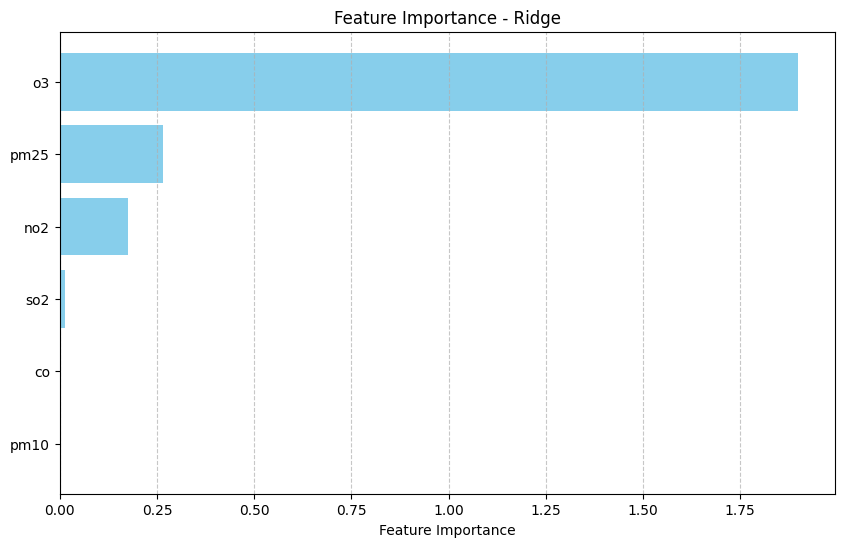

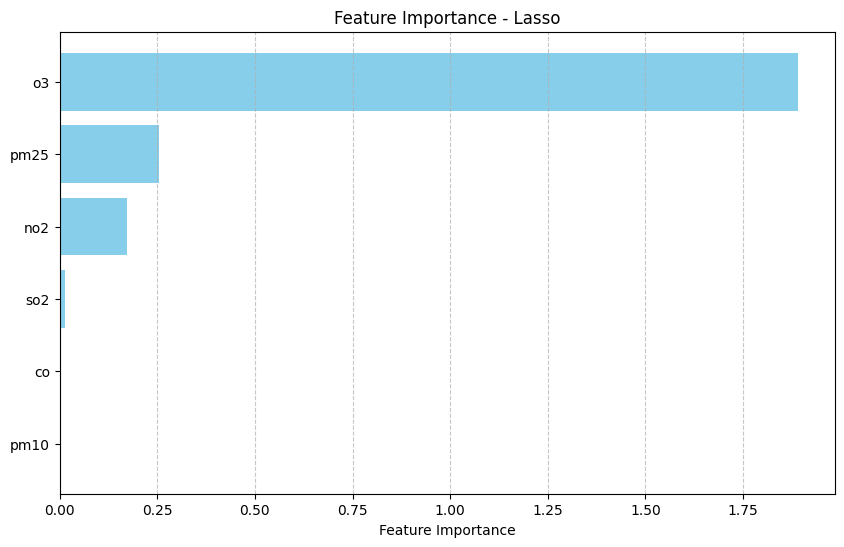

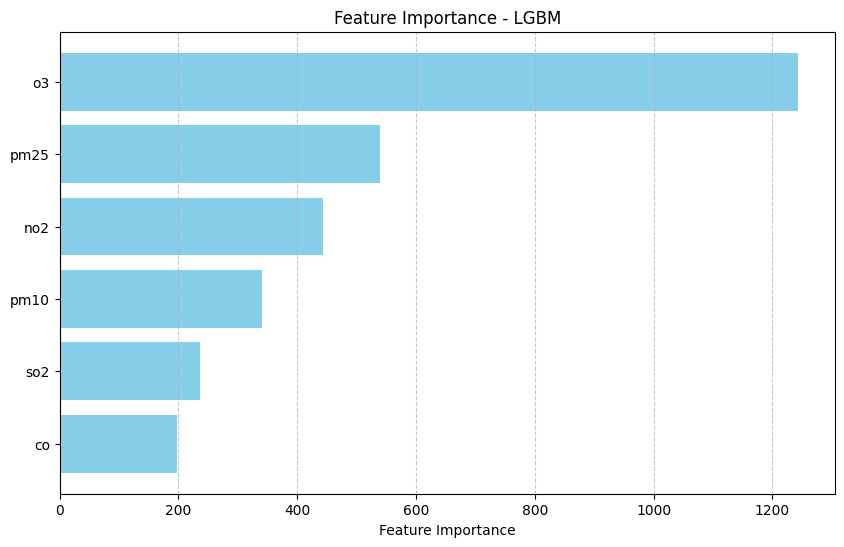

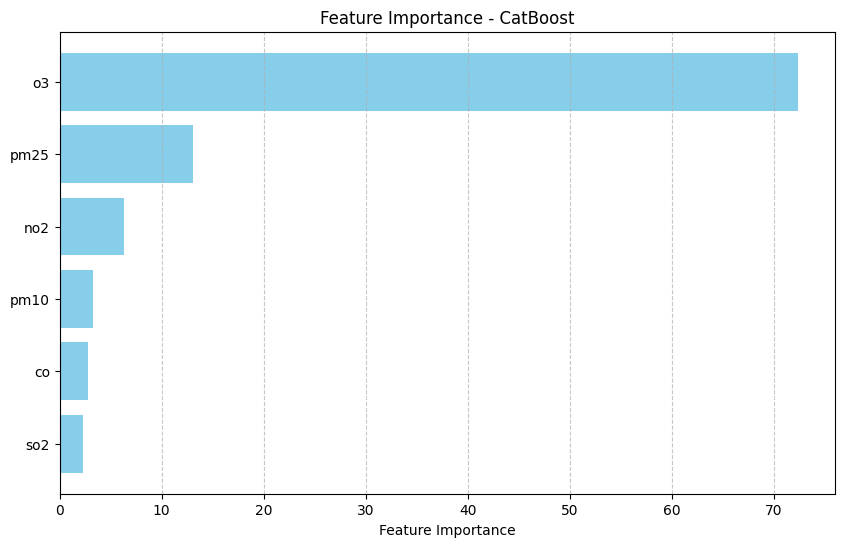

In [ ]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

for name, model in models.items():
    if hasattr(model, "feature_importances_"):  # for tree-based models
        importances = model.feature_importances_
    else:  # the rest - use permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean

    sorted_idx = numpy.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance - {name}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

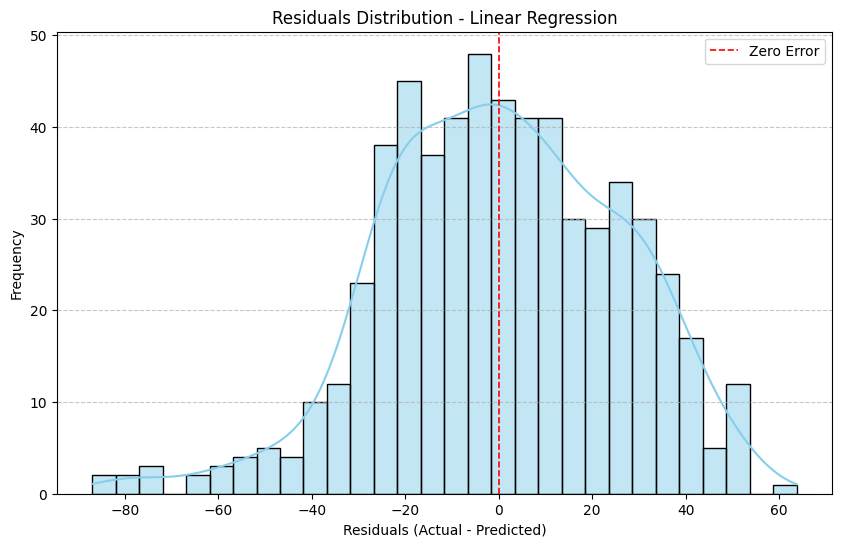

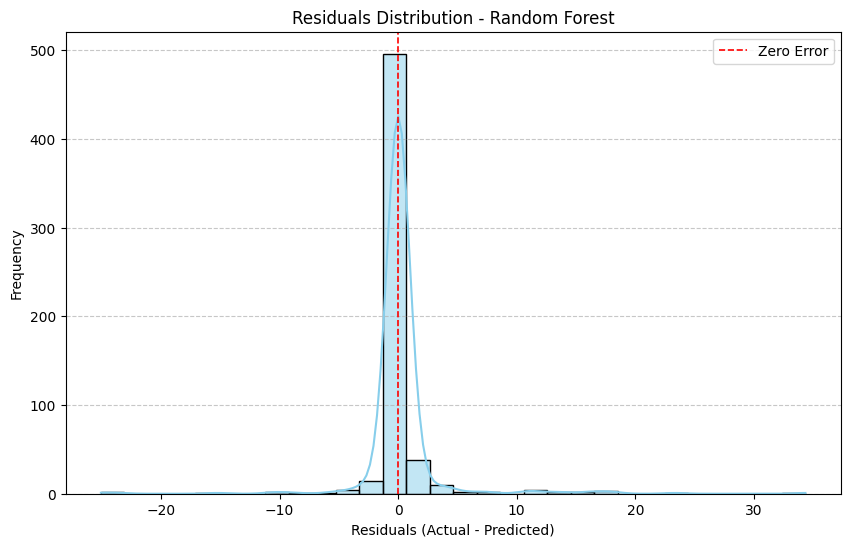

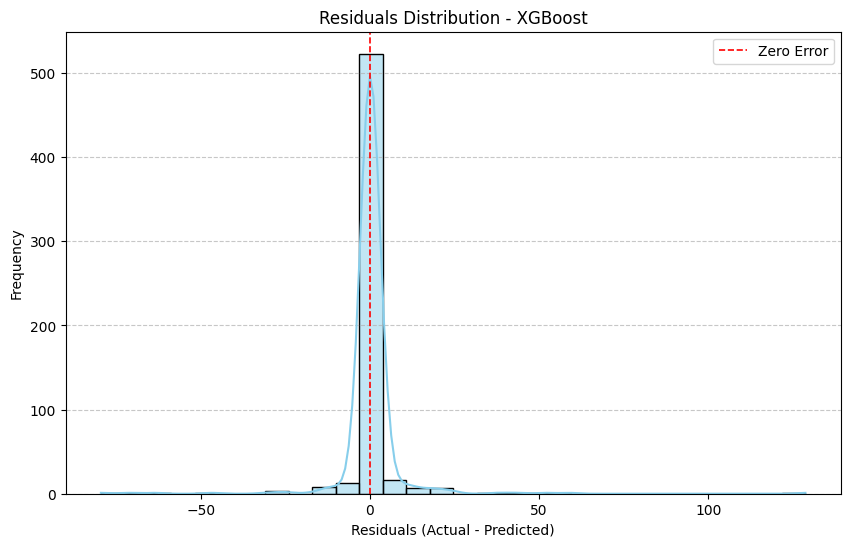

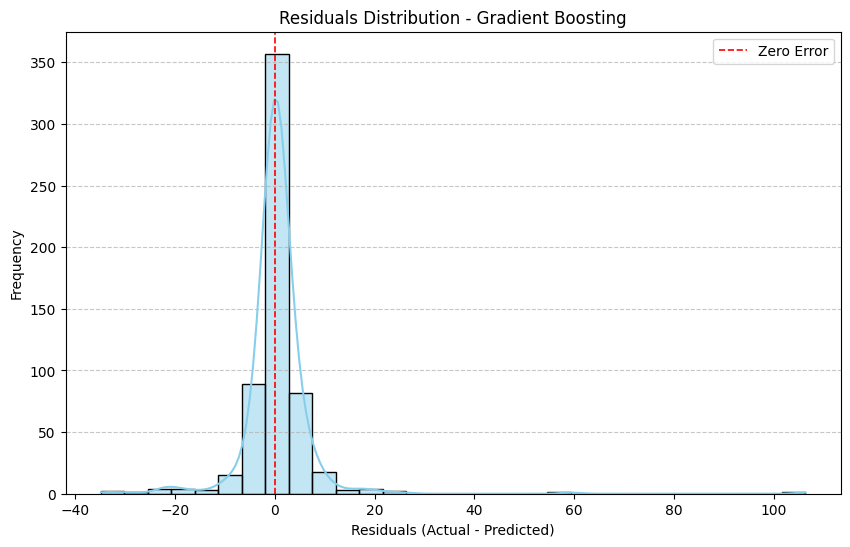

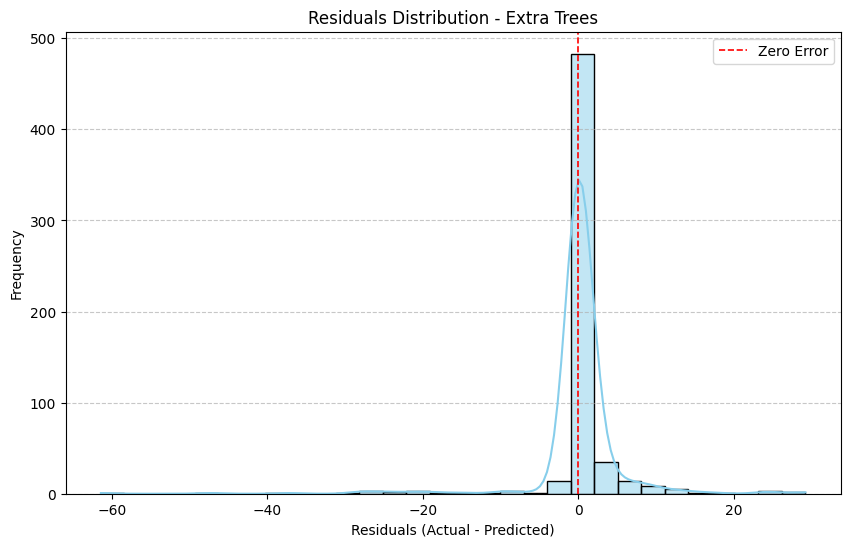

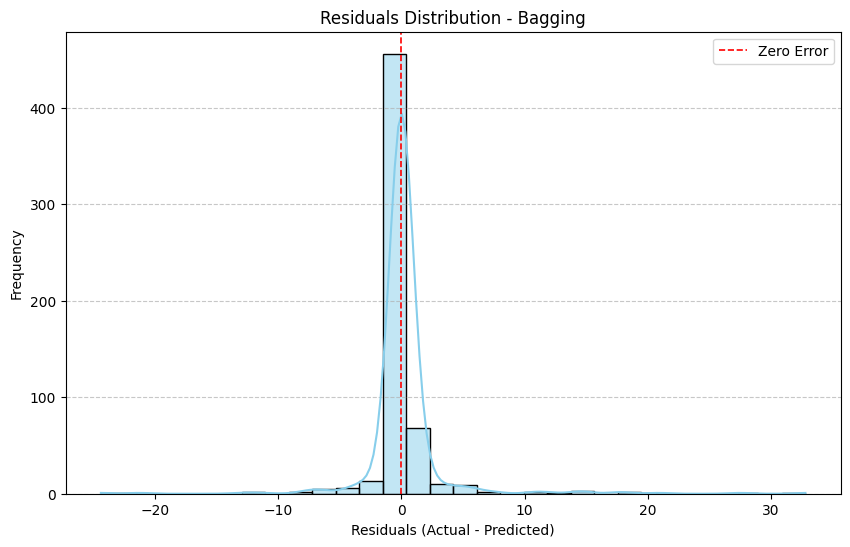

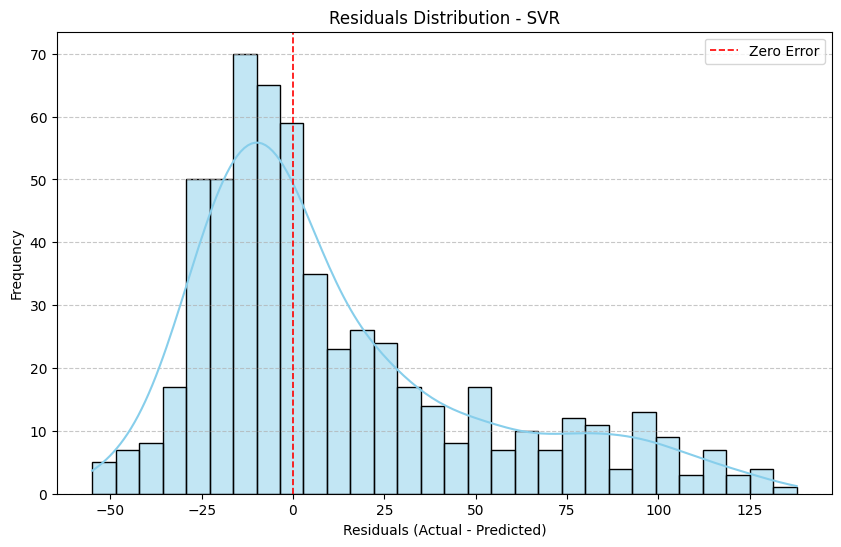

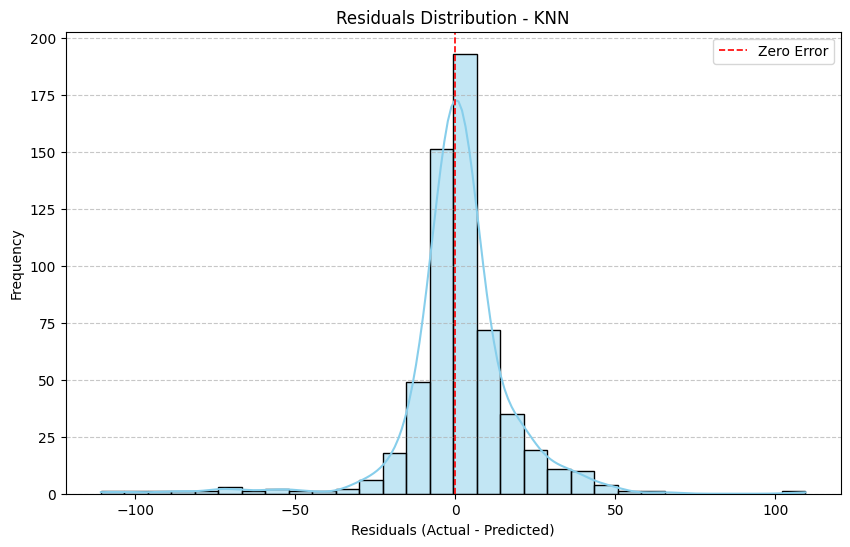

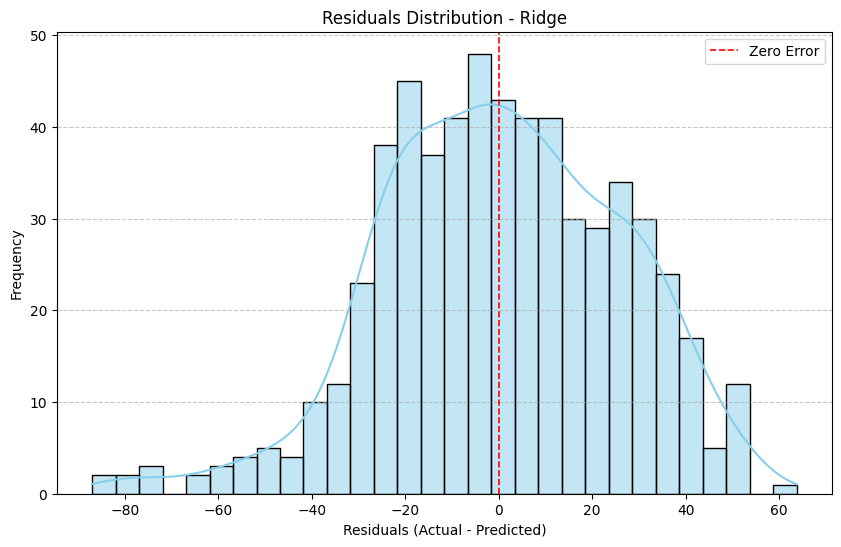

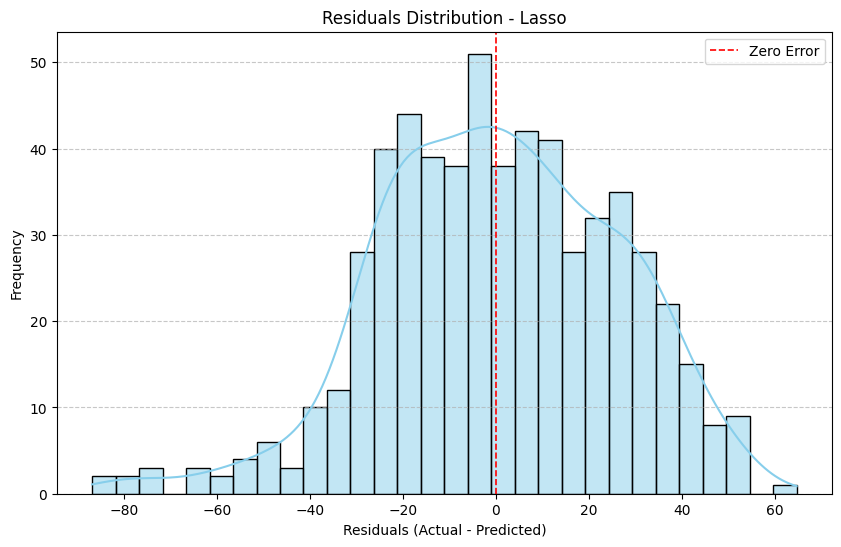

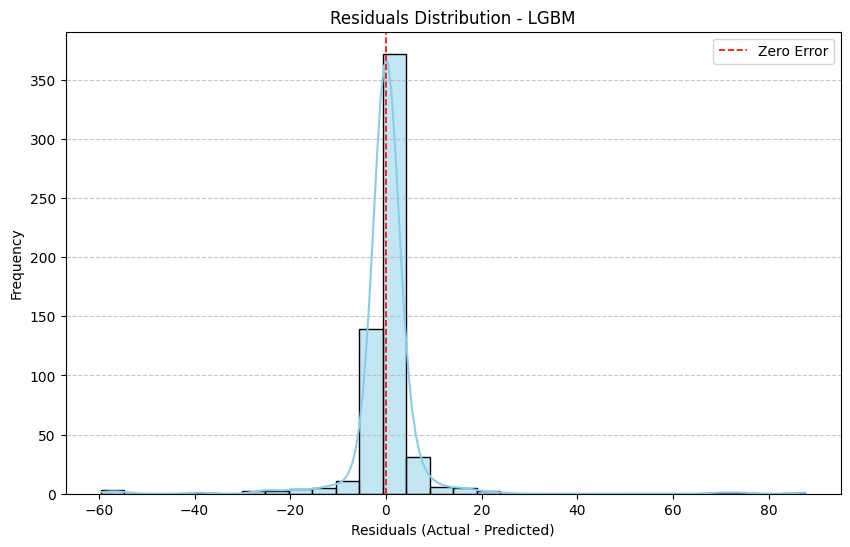

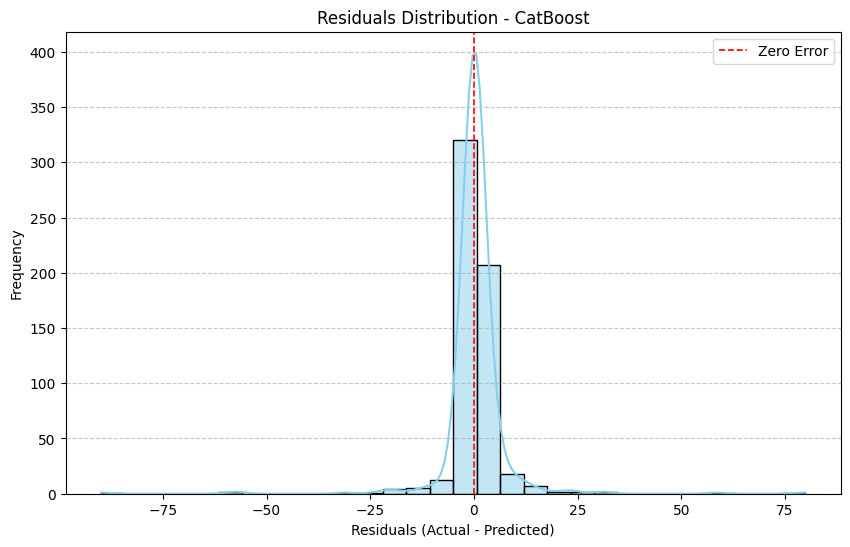

In [ ]:
for name, model in models.items():
    preds = model.predict(X_test)
    residuals = y_test - preds
    
    plt.figure(figsize=(10, 6))
    seaborn.histplot(residuals, kde=True, color="skyblue", bins=30, edgecolor="black")
    plt.title(f"Residuals Distribution - {name}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=1.2, label="Zero Error")
    plt.legend()
    plt.show()